# Predicting House Price in Ames

## Introduction

House purchase is one of the biggest spending in most of people's life. It is uncommon for people to spend decades to fully paid the loan of their first house. This leads many first time buyers to have no/ little idea on the fair price of an estate as there are plenty of factors to consider. In this project, I will attempt to build a House Price prediction model using data obtained from historical property transaction in Ames, Iowa from 2006 and 2010. The dataset is obtained from a 2018 Kaggle 'DSI-US-6 Project 2 Regression Challenge' [link](https://www.kaggle.com/c/dsi-us-6-project-2-regression-challenge). 

The data consists of 2051 transactions with 80 features consisting of 23 nominal (categorical features with no particular order), 23 ordinal (categorical features with some natural order), 14 discrete (numerical features but within some intervals) and 20 continuous variables (numerical features with no particular binning and can take any value). The full data dictionary can be seen [here](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt). 

## Problem Statement

The objective of the study is two folds:
- First, to create a prediction model that accurately predict house price with reasonable error margin
- Second, to ensure that the model generalized well to perform equally well on the data points it never see before

Apart from these two objectives, I wish to obtain some insights on:
- Which features significantly affects the house price?
    - To help buyer and seller alike to understand which feature of the house is crucial to determine the house price
- Is there any close correlation between different features?
    - To optimize data collection effort in the future to build a better price prediction model

## Executive Summary

In this project, I attempted to create a prediction model to fulfill the objective mentioned previously using Linear Regression model. Linear Regression is an approach to model a relationship between a scalar continuous target variable from explanatory variables associated with it ([source](https://en.wikipedia.org/wiki/Linear_regression)). 

The simplest form of linear regression can be formulated into a line equation of *y=mx+c* for a single predictor feature (*x*) to predict target variable (*y*). In this simple example, the model will 'learn' by fitting the predicted *y* to the actualy *y* by adjusting the value of *m* (gradient) and *c* (intercept). So superimpose it to our problem, the model will generally take a form of *SalePrice* = *Gradient* x *X* + *Intercept* with *X* is an array containing the explanatory variables values. From now on, these explanatory variables will be referred to as *features* or *variables* for brevity. 

However, as linear regression only take in numerical values for its features to ensure that we can do the modelling. Another issue we may encounter is the fact that we have 80 features, which may cause us to overfit the data instead of having a generalized predictor for the SalePrice value. Therefore a set of strategy will be set to overcome this problem elaborated in the [Proposed Approach](#Proposed-Approach) section.

### Proposed Approach

In general, the strategy we have in addressing the issues above are:

**1. Linear Regression only takes numerical values to model**
- Categorical features (nominal and ordinal) will be converted into some numerical representation by the means of One Hot Encoding (binarize the category into an array of 1 and 0 to represent the feature) or Ordinal Encoding (convert category to numerical values which retains the order of category).

**2. Selection of significant features**
- Remove features with majority counts for a single category. This feature may not provide extra information as most data falls under the same category. 
- Remove features with high correlation with one another. However, to ensure that important information is retained, one of the feature will be retained. 
- Regularization using Lasso, Ridge and Elastic Net to penalize having unnecessary features.

The approach I take to perform the feature selection (especially true for the first two points) is to be as objective as possible by parameterizing the model and perform a grid search over a range of values to obtain the best parameter for the model. These high level parameters are contained in section [Parameter Setting](#Parameter-Setting), subsequently. 

### List of Content

- [1. Predicting House Price in Ames](#Predicting-House-Price-in-Ames)
 - [1.1 Introduction](#Introduction)
 - [1.2 Problem Statement](#Problem-Statement)
 - [1.3 Executive Summary](#Executive-Summary)
 - [1.4 Parameter Setting](#Parameter-Setting)
- [2. Training Set](#Training-Set)
 - [2.1 Import](#Import)
 - [2.2 Data Cleaning](#Data-Cleaning)
 - [2.3 Exploratory Data Analysis](#Exploratory-Data-Analysis)
 - [2.4 Feature Selection](#Feature-Selection)
 - [2.5 Preprocessing](#Preprocessing)
 - [2.6 Linear Model](#Linear-Model)
 - [2.7 Best Model Training](#Best-Model-Training)
 - [2.8 Parameter Setting](#Parameter-Setting)
- [3. Test set](#Test-Set)
 - [3.1 Import Test Data](#Import-Test-Data)
 - [3.2 Test Data Cleaning](#Test-Data-Cleaning)
 - [3.3 Polynomial Feature and Scaling](#Polynomial-Feature-and-Scaling)
 - [3.4 Test Prediction](#Test-Prediction)
- [4. Summary](#Summary)
 - [4.1 Parameter Setting Summary](#Parameter-Setting-Summary)
 - [4.2 Effect of Outlier Summary](#Effect-of-Outlier-Summary)
 - [4.3 Feature Selection Summary](#Feature-Selection-Summary)
- [5. Conclusion](#Conclusion)

## Parameter Setting

This chapter will provide high level parameter to perform feature selection and polynomial feature generation.  While the purpose of feature selection is explained previusly, the purpose of the polynomial feature generation will be explained.

### Feature Selection Parameters

The threshold is set to dictate the parameters that can go through to the next stage of processing. The higher the number of threshold, the easier the parameter can pass through, therefore, the more lenient it is. 

In [1]:
# Parameter set here are of the most optimum to create the best model with low bias and variance
# For more information, check 'Selected Features' section under 'Parameter Setting'

# Number of majority count threshold 
# for both categorical and numerical features
maj_threshold = 0.7

# Multicollinearity first threshold
# for numerical features only
# it is used to select feature to be used to perform polynomial features to
# only features with linear correlation < the threshold to the rest of parameters will be used subsequently
mul_threshold_init = 0.9

# Multicollinearity second threshold
# for numerical features only
# it is used to select feature after polynomial features is performed
# only features with linear correlation < the threshold to the rest of parameters will be used subsequently
mul_threshold_final = 0.9

# Number of noncat features
# for numerical features only
# it is used to select top features to be used to train the model
# only model in the top #noncat_count will be used to train the model
noncat_count = 25

### Polynomial Feature Parameters

This is the section to set if polynomial features such as root terms, log terms, quadratic and interaction terms is to be set. By changing the values and restarting the notebook, we will be able to find the best model with the least RMSE.

In [2]:
# There is root relation between independent and dependent variable
root_variable = False
root_after_pf = False

# There is log relation between independent and dependent variable
log_variable = False
log_after_pf = False

# Turn on Polynomial features
poly_on = True

# Training Set

## Import

### Import Libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import itertools
import time
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from scipy.stats import chi2_contingency, pearsonr

### Import Data

In [4]:
# Import and view the data
ames = pd.read_csv('datasets/train.csv')
ames.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [5]:
print("There are {} data point with {} columns.".format(ames.shape[0],ames.shape[1]))

There are 2051 data point with 81 columns.


## Data Cleaning

In [6]:
ames.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'G

In [7]:
ames.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [8]:
ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

In [9]:
pd.set_option('display.max_columns', None) # to show all columns

In [10]:
null_df = pd.DataFrame(data=ames.isnull().sum(), columns=['Null Count'])
null_df.rename_axis('Columns')
null_df['Null Percentage'] = null_df['Null Count'].map(lambda x: round((x/len(ames))*100,1))
null_df.T

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
Null Count,0.0,0.0,0.0,0.0,330.0,0.0,0.0,1911.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,22.0,0.0,0.0,0.0,55.0,55.0,58.0,55.0,1.0,56.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,113.0,114.0,114.0,1.0,1.0,114.0,114.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2042.0,1651.0,1986.0,0.0,0.0,0.0,0.0,0.0
Null Percentage,0.0,0.0,0.0,0.0,16.1,0.0,0.0,93.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.1,1.1,0.0,0.0,0.0,2.7,2.7,2.8,2.7,0.0,2.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.8,5.5,5.6,5.6,0.0,0.0,5.6,5.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.6,80.5,96.8,0.0,0.0,0.0,0.0,0.0


### NA Values Handling

List down column containing empty data

In [11]:
empty_cols = [column for column in ames.columns if ames[column].isnull().sum()>0]
np.array(empty_cols)

array(['Lot Frontage', 'Alley', 'Mas Vnr Type', 'Mas Vnr Area',
       'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1',
       'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF',
       'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath',
       'Fireplace Qu', 'Garage Type', 'Garage Yr Blt', 'Garage Finish',
       'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond',
       'Pool QC', 'Fence', 'Misc Feature'], dtype='<U14')

#### Features with < 10% rows filled

As the data is likely to not affect the final result, it will first be drop for now. 

In [12]:
# List column names with <10% rows filled
cols_10 = [column for column in ames.columns if ames[column].notnull().sum() < len(ames)*0.1]
cols_10

['Alley', 'Pool QC', 'Misc Feature']

In [13]:
def null_plotter(dataframe, columns):
    df = pd.DataFrame({'Null Count':dataframe[columns].isnull().sum()})
    df.rename_axis('Feature', inplace=True)
    df.sort_values(by='Null Count', ascending=False,inplace=True)
    df['% Null'] = df['Null Count'].map(lambda x: round(x*100/len(dataframe),1))
    df['% Filled'] = 100 - df['% Null']
    n = len(df)

    plt.figure(figsize=(2*n,6))
    plt.bar(df.index, df['% Filled'] , color='blue', edgecolor='white', label='% Filled')
    plt.bar(df.index, df['% Null'], bottom=df['% Filled'] , color='red', edgecolor='white', label='% Null');
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
    plt.ylabel("Percentage of Rows (%)", fontsize=12);

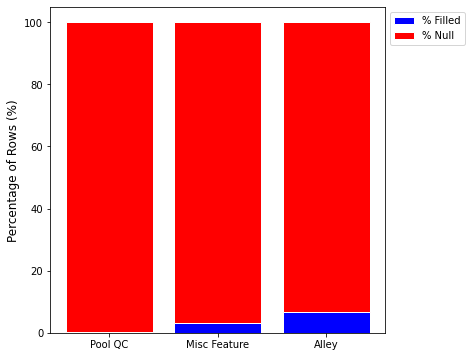

In [14]:
null_plotter(ames, cols_10)

In [15]:
# drop column with <10% rows filled
ames.drop(labels=cols_10, axis=1,inplace=True)

#### Features with 10-90% Data Filled

In [16]:
# List column names with <90% rows filled
cols_90 = [column for column in ames.columns if ames[column].notnull().sum() < len(ames)*0.9]
cols_90

['Lot Frontage', 'Fireplace Qu', 'Fence']

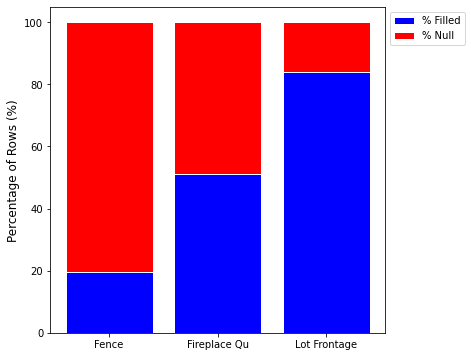

In [17]:
null_plotter(ames, cols_90)

In [18]:
## Lets understand the the nature of Fireplace Quality, Lot Frontage, Fence and Fireplace Quality 
## columns one by one

In [19]:
## 1. Fence

### Let's check if empty Fence column corresponds to lack of Fence
print("Number of missing rows: {}".format(ames['Fence'].isnull().sum()))

### We do not drop 'Fence' column as NA indicates the lack of fence.
ames['Fence'].replace(np.NaN,'No Fence',inplace=True)

Number of missing rows: 1651


In [20]:
## 2. Fireplace Quality

### Let's check if empty Fireplace Quality column corresponds to lack of fireplace
print("Number of missing rows: {}".format(ames['Fireplace Qu'].isnull().sum()))

ames.groupby(['Fireplace Qu','Fireplaces'],dropna=False)[['Id']].count()

Number of missing rows: 1000


Id
Fireplace Qu Fireplaces      
Ex           1             29
             2              2
Fa           1             49
             2              9
             3              1
Gd           1            447
             2             74
             3              2
Po           1             31
TA           1            342
             2             61
             3              3
             4              1
NaN          0           1000

In [21]:
### Therefore, we can conclude that NA 'Fireplace Quality' column indicates the lack of fireplace
ames['Fireplace Qu'].replace(np.NaN,'No Fireplace',inplace=True)

In [22]:
## 3. Lot Frontage

### Number of missing values
print("Number of missing rows: {}".format(ames['Lot Frontage'].isnull().sum()))

Number of missing rows: 330


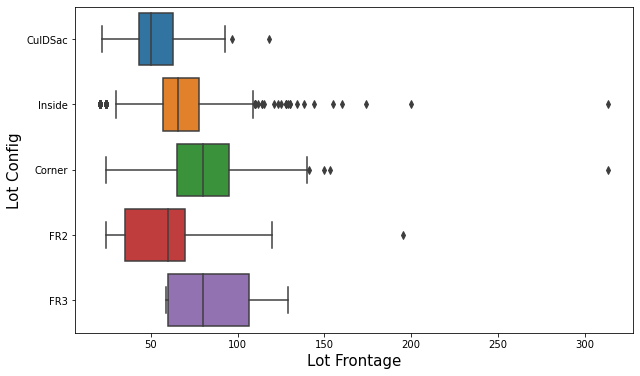

In [23]:
### Check the distribution of Lot Frontage based on its config
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(y='Lot Config',
            x='Lot Frontage',
            data=ames,
           ax=ax);

ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15);

In [24]:
### As there is certain correlation between Lot Frontage and config, i.e. different Lot Config has unique spreading
### Let's impute Lot Frontage value based on the mean Lot Frontage per Lot Config

Despite the fact that simple imputation through mean is not recommended for both training and validation set, it will still be done this way as the spread of Lot Frontage is not significant and unlikely will cause a huge adverse affect for the final result.

In [25]:
### As there is certain correlation between Lot Frontage and config
### Let's impute Lot Frontage value based on the mean Lot Frontage per Lot Config

### Create index of missing Lot Frontage (nan)
ind = ames[ames['Lot Frontage'].isnull()][['Lot Frontage','Lot Config']].index

### Create types of Lot Configs
lcs = ames['Lot Config'].unique()

### Create a dictionary with key: 'Lot Config' and value 'Mean value of Lot Frontage'
dic_lf = dict()
for lc in lcs:
    dic_lf[lc] = ames[ames['Lot Config']==lc]['Lot Frontage'].mean()

### Replace nan Lot Frontage with average Lot Frontage for each Lot Config
for i in ind:
    key = ames.iloc[i,:]['Lot Config']
    lot_mean = dic_lf[key]
    ames.at[i,'Lot Frontage'] = lot_mean

#### Features with Some Missing Data (>= 90% filled)

In [26]:
# List column names with >=90% but <100% rows filled
cols_90_100 = [column for column in ames.columns if 
        (ames[column].notnull().sum() >= len(ames)*0.9) &
       (ames[column].notnull().sum() < len(ames)*1)]
np.array(cols_90_100)

array(['Mas Vnr Type', 'Mas Vnr Area', 'Bsmt Qual', 'Bsmt Cond',
       'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Type', 'Garage Yr Blt',
       'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual',
       'Garage Cond'], dtype='<U14')

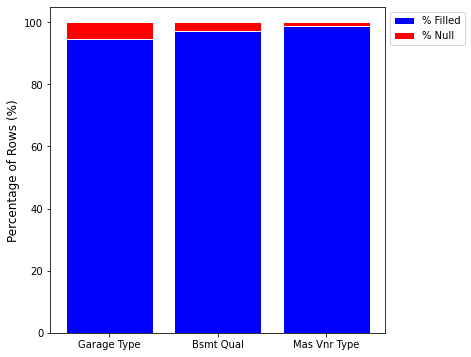

In [27]:
null_plotter(ames, ['Mas Vnr Type','Bsmt Qual', 'Garage Type'])

There are few related topics: Masonry (Mas), Basement (Bsmt) and Garage. We will deal with them separately.

##### Masonry 

In [28]:
## Masonry
print("Number of missing rows (type): {}".format(ames['Mas Vnr Type'].isnull().sum()))
print("Number of missing rows (area): {}".format(ames['Mas Vnr Area'].isnull().sum()))
print("Number of missing rows (both): {}".format((ames['Mas Vnr Area'].isnull() & ames['Mas Vnr Area'].isnull()).sum()))

Number of missing rows (type): 22
Number of missing rows (area): 22
Number of missing rows (both): 22


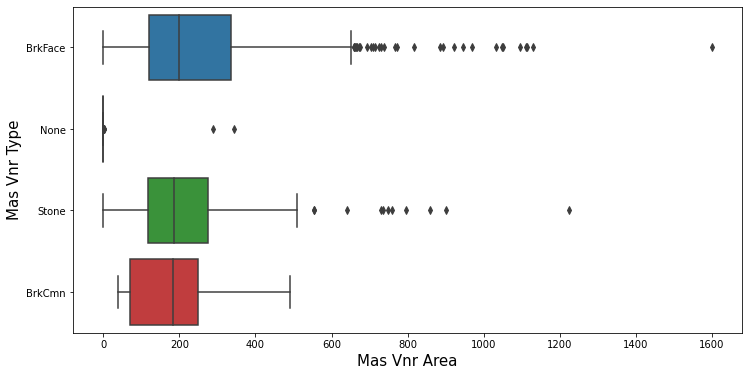

In [29]:
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(y='Mas Vnr Type',
            x='Mas Vnr Area',
            data=ames,
            ax=ax);

ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15);

In [30]:
ames.groupby('Mas Vnr Type')['Id'].count()

Mas Vnr Type
BrkCmn       13
BrkFace     630
None       1218
Stone       168
Name: Id, dtype: int64

A few observations:
- There are 22 rows with both type and area 
- Most of data points shows None in Masonry type. Therefore, it will be safe to impute None for the 22 empty rows. 
- There are a few data points with type: None but have >0 area. This values will be imputed to 0

In [31]:
### None Masonry Type and Area filled accordingly
ames['Mas Vnr Type'].fillna('None',inplace=True)
ames['Mas Vnr Area'].fillna(0, inplace=True)

In [32]:
### Check non-zero area where type is 'None'
ames[(ames['Mas Vnr Type']=='None') & (ames['Mas Vnr Area']!= 0)][['Mas Vnr Type','Mas Vnr Area']]

,Mas Vnr Type,Mas Vnr Area
765,None,1.0
810,None,288.0
1148,None,1.0
1684,None,1.0
1832,None,344.0


In [33]:
### Generate the index of row to amend the value
ind = ames[(ames['Mas Vnr Type']=='None') & (ames['Mas Vnr Area']!= 0)].index

### Replace the value to 0
for i in ind:
    ames.at[i,'Mas Vnr Area'] = 0

##### Basement

In [34]:
# List down columns related to basement
col_bsmt = [column for column in ames.columns if 'bsmt' in column.lower()]
np.array(col_bsmt)

array(['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1',
       'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF',
       'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath'], dtype='<U14')

In [35]:
## Counts of missing rows per column
ames[col_bsmt].isnull().sum()

Bsmt Qual         55
Bsmt Cond         55
Bsmt Exposure     58
BsmtFin Type 1    55
BsmtFin SF 1       1
BsmtFin Type 2    56
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Bsmt Full Bath     2
Bsmt Half Bath     2
dtype: int64

There are two categories of columns with null values, one with >50 empty columns, the other one with <5 columns. We will treat them differently.

In [36]:
## Column with >50 empty rows
ames[(ames['Bsmt Qual'].isnull()) &
     (ames['Bsmt Cond'].isnull()) &
     (ames['Bsmt Exposure'].isnull()) &
     (ames['BsmtFin Type 1'].isnull()) &
    (ames['BsmtFin Type 2'].isnull())][['Id']].count()

Id    55
dtype: int64

In [37]:
## As these 55 rows have no details on any Bsmt category, we will assume that they dont have any basement.
## Create a list of index for the 55 data
ind = ames[(ames['Bsmt Qual'].isnull()) &
         (ames['Bsmt Cond'].isnull()) &
         (ames['Bsmt Exposure'].isnull()) &
         (ames['BsmtFin Type 1'].isnull()) &
        (ames['BsmtFin Type 2'].isnull())].index
ind

Int64Index([  12,   93,  114,  146,  183,  240,  249,  256,  390,  437,  485,
             499,  514,  580,  581,  616,  635,  642,  696,  700,  737,  772,
             790,  794,  924,  933,  954, 1007, 1022, 1049, 1089, 1098, 1125,
            1157, 1211, 1222, 1252, 1256, 1270, 1327, 1331, 1377, 1387, 1428,
            1481, 1594, 1620, 1681, 1684, 1686, 1859, 1875, 1889, 1933, 2010],
           dtype='int64')

In [38]:
## Lets impute all these data with its default no basement values
for i in ind:
    ames.at[i,'Bsmt Qual'] = 'NA'
    ames.at[i,'Bsmt Cond'] = 'NA'
    ames.at[i,'Bsmt Exposure'] = 'NA'
    ames.at[i,'BsmtFin Type 1'] = 'NA'
    ames.at[i,'BsmtFin Type 2'] = 'NA'

In [39]:
## Counts of missing rows per column after imputation of the 55 data
ames[col_bsmt].isnull().sum()

Bsmt Qual         0
Bsmt Cond         0
Bsmt Exposure     3
BsmtFin Type 1    0
BsmtFin SF 1      1
BsmtFin Type 2    1
BsmtFin SF 2      1
Bsmt Unf SF       1
Total Bsmt SF     1
Bsmt Full Bath    2
Bsmt Half Bath    2
dtype: int64

In [40]:
## Column with <5 empty rows

### Bsmt Exposure
ames[ames['Bsmt Exposure'].isnull()][col_bsmt]  # <-- These three houses have basement. 
                                                # Default will be imputed as 'No Exposure'
ind = ames[ames['Bsmt Exposure'].isnull()].index
for i in ind: 
    ames.at[i,'Bsmt Exposure'] = 'No'

In [41]:
### BsmtFin SF 1
ames[ames['BsmtFin SF 1'].isnull()][col_bsmt]   # <-- This house does not have a basement
                                                # Will be imputed as 'No Basement'
ames.at[ames[ames['BsmtFin SF 1'].isnull()].index,'BsmtFin SF 1'] = 0

In [42]:
### BsmtFin Type 2
ames[ames['BsmtFin Type 2'].isnull()][col_bsmt] # <-- This house have a basement and has some unfinished area
                                                # Will be imputed as 'Unfinished'
ames.at[ames[ames['BsmtFin Type 2'].isnull()].index,'BsmtFin Type 2'] = 'Unf'

In [43]:
### BsmtFin SF 2, Bsmt Unf SF, Total Bsmt SF, Bsmt Full Bath, Bsmt Half Bath
ames[ames['BsmtFin SF 2'].isnull()][col_bsmt] # <-- This house have no basement with NaN at 5 columns. 
                                              # Will be imputed as 0 or No Basement accordingly
ames.at[ames[ames['BsmtFin SF 2'].isnull()].index,'BsmtFin SF 2'] = 0
ames.at[ames[ames['Bsmt Unf SF'].isnull()].index,'Bsmt Unf SF'] = 0
ames.at[ames[ames['Total Bsmt SF'].isnull()].index,'Total Bsmt SF'] = 0
ames.at[ames[ames['Bsmt Full Bath'].isnull()].index,'Bsmt Full Bath'] = 0
ames.at[ames[ames['Bsmt Half Bath'].isnull()].index,'Bsmt Half Bath'] = 0

##### Garage

In [44]:
# List down columns related to garage
col_gar = [column for column in ames.columns if 'garage' in column.lower()]
np.array(col_gar)

array(['Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars',
       'Garage Area', 'Garage Qual', 'Garage Cond'], dtype='<U13')

In [45]:
## Counts of missing rows per column
ames[col_gar].isnull().sum()

Garage Type      113
Garage Yr Blt    114
Garage Finish    114
Garage Cars        1
Garage Area        1
Garage Qual      114
Garage Cond      114
dtype: int64

In [46]:
# Check how many data points with null values across 5 rows
ames[(ames['Garage Type'].isnull()) &
     (ames['Garage Yr Blt'].isnull()) &
     (ames['Garage Finish'].isnull()) &
     (ames['Garage Qual'].isnull()) &
    (ames['Garage Cond'].isnull())][['Id']].count()

Id    113
dtype: int64

In [47]:
## As these 113 rows have no details on any Garage category, we will assume that they dont have any Garage.
## Create a list of index for the 113 data
ind = ames[(ames['Garage Type'].isnull()) &
         (ames['Garage Yr Blt'].isnull()) &
         (ames['Garage Finish'].isnull()) &
         (ames['Garage Qual'].isnull()) &
        (ames['Garage Cond'].isnull())].index
ind

Int64Index([  28,   53,   65,   79,  101,  103,  114,  120,  134,  136,
            ...
            1841, 1893, 1927, 1952, 1982, 1991, 2010, 2027, 2039, 2042],
           dtype='int64', length=113)

In [48]:
## Impute values with No Garage
for i in ind:
    ames.at[i,'Garage Type'] = 'NA'
#     ames.at[i,'Garage Yr Blt'] = 'NA' ## <-- needs to accept integer value
    ames.at[i,'Garage Finish'] = 'NA'
    ames.at[i,'Garage Qual'] = 'NA'
    ames.at[i,'Garage Cond'] = 'NA'

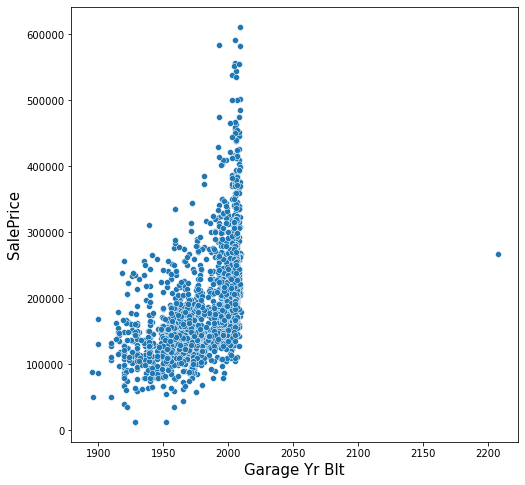

In [49]:
## Observe if Garage Yr Blt has any relation with the SalePrice

fig, ax = plt.subplots(figsize=(8,8))

sns.scatterplot(
    data=ames,
    y='SalePrice',
    x='Garage Yr Blt',
    ax=ax
);

ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15);

In [50]:
ames[['Garage Yr Blt','Year Built','SalePrice']].corr()

,Garage Yr Blt,Year Built,SalePrice
Garage Yr Blt,1.000000,0.825316,0.533922
Year Built,0.825316,1.000000,0.571849
SalePrice,0.533922,0.571849,1.000000


**Observations:**<br>
- Despite having a good correlatoin with SalePrice, Garage Yr Built also have a high correlation with the Year Built variable. Therefore, we will drop this column for now. 

In [51]:
ames.drop(labels='Garage Yr Blt', axis=1,inplace=True)

In [52]:
col_gar = [column for column in ames.columns if 'garage' in column.lower()]
np.array(col_gar)

array(['Garage Type', 'Garage Finish', 'Garage Cars', 'Garage Area',
       'Garage Qual', 'Garage Cond'], dtype='<U13')

In [53]:
ames[col_gar].isnull().sum()

Garage Type      0
Garage Finish    1
Garage Cars      1
Garage Area      1
Garage Qual      1
Garage Cond      1
dtype: int64

In [54]:
# Single row with 5 empty columns. We will drop this row for now. 
ind = ames[(ames['Garage Finish'].isnull()) &
     (ames['Garage Cars'].isnull()) &
     (ames['Garage Area'].isnull()) &
     (ames['Garage Qual'].isnull()) &
    (ames['Garage Cond'].isnull())][col_gar].index

ames[(ames['Garage Finish'].isnull()) &
     (ames['Garage Cars'].isnull()) &
     (ames['Garage Area'].isnull()) &
     (ames['Garage Qual'].isnull()) &
    (ames['Garage Cond'].isnull())][col_gar]

,Garage Type,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond
1712,Detchd,NaN,NaN,NaN,NaN,NaN


In [55]:
## Drop the row with 5 empty columns
ames.drop(index=ind, axis=0,inplace=True)
ames.reset_index(inplace=True)

In [56]:
print("Number of empty cell in the dataset: {}.".format(ames.isnull().sum().sum()))

Number of empty cell in the dataset: 0.


### Outlier Removal

As described in the data description, there are a few outliers which may skew the accuracy of the model. Therefore, we will remove the data as it does not represent the general trend of house price. 

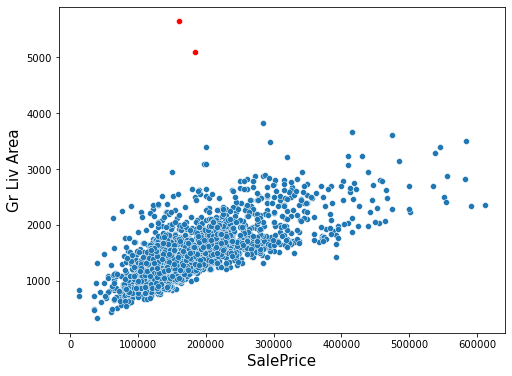

In [57]:
fig, ax = plt.subplots(figsize=(8,6))

sns.scatterplot(
    data=ames[ames['Gr Liv Area']<=4000],
    x='SalePrice',
    y='Gr Liv Area',
    ax=ax
)
sns.scatterplot(
    data=ames[ames['Gr Liv Area']>4000],
    x='SalePrice',
    y='Gr Liv Area',
    color='red',
    ax=ax
)

ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15);

Outliers are shown in red. We will remove them accordingly. 

In [58]:
# NOTE: If this block is commented, outliers will not be removed

# ames.drop(labels=ames[ames['Gr Liv Area']>4000].index, inplace=True, axis=0)
# ames.reset_index(drop=True, inplace=True)

## Exploratory Data Analysis

Having cleaned the data, we will now explore the data to understand its underlying distribution.

### Non-categorical Features

In [59]:
# Convert MS SubClass to be included into categorical features
ames.loc[:,'MS SubClass'] = ames.loc[:,'MS SubClass'].map(lambda x: str(x))

In [60]:
# List down the categorical features

def categorical_features(df):
    lst=[]
    for col in df.columns:
        if ((df[col].dtype == 'object')) & (len(df[col].unique())<=30):
            lst.append(col)
    return lst

cat_features = categorical_features(ames)
np.array(cat_features)

array(['MS SubClass', 'MS Zoning', 'Street', 'Lot Shape', 'Land Contour',
       'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood',
       'Condition 1', 'Condition 2', 'Bldg Type', 'House Style',
       'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd',
       'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Foundation',
       'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1',
       'BsmtFin Type 2', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', 'Kitchen Qual', 'Functional', 'Fireplace Qu',
       'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond',
       'Paved Drive', 'Fence', 'Sale Type'], dtype='<U14')

In [61]:
# Numerical features are features which is not covered in categorical features

noncat_features = [col for col in ames.columns if col not in cat_features]

In [62]:
# Develop a function to mass plot numerical features
def scatterplotter(df, list_of_columns, target):    
    ncols = 3
    nrows = int((len(list_of_columns)/ncols))+1
    
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, nrows*4))
    ax = ax.ravel()
    
    for i, col in enumerate(list_of_columns):
        sns.regplot(data=df,
                    x=col,
                    y=target,
                    ax=ax[i],
                    line_kws={'color':'red'})
        ax[i].set_title(col, fontsize=14)
        ax[i].set_xlabel('')
        plt.tight_layout()
        ax[i].yaxis.label.set_size(15);
    
    plt.suptitle('Scatterplot of Numerical Features vs Sale Price', fontsize=30, y=1.01)

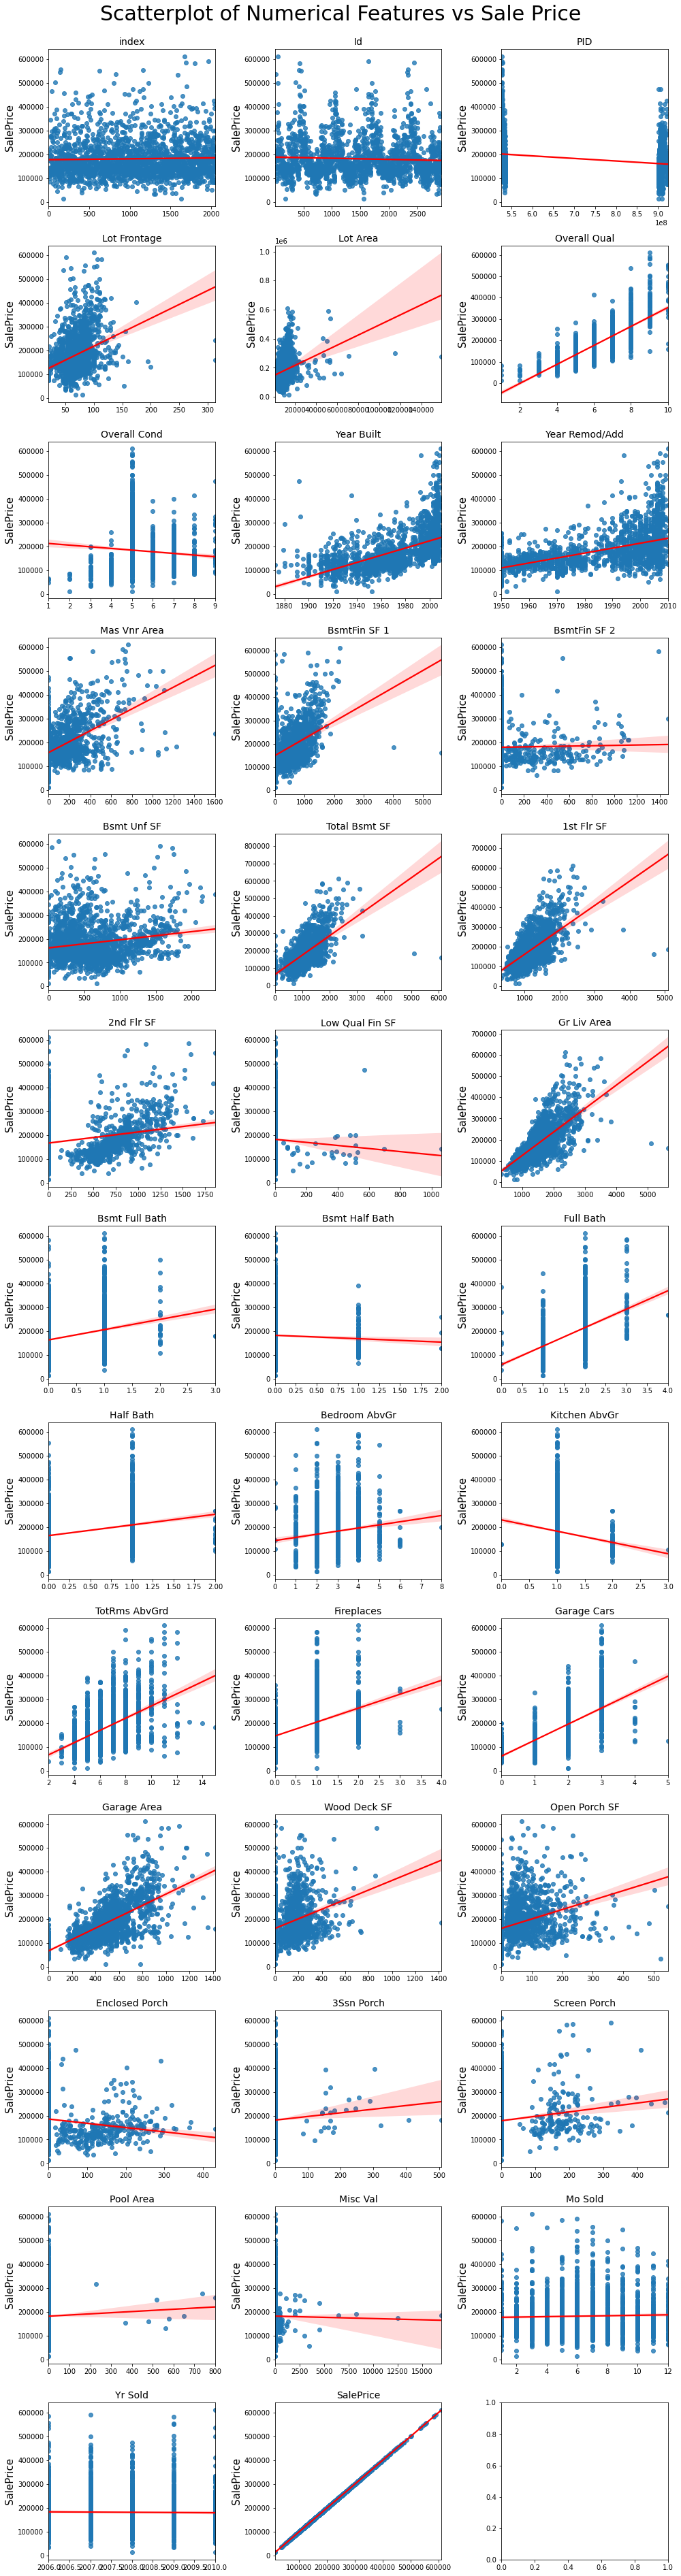

In [63]:
scatterplotter(ames, noncat_features, 'SalePrice')

**Observations:**<br>
- There are a few features with some linear correlation with the SalePrice such as 'Overall Qual', 'Year Built' and 'Gr Liv Area'
- However, most of the other features do not have clear relation with the SalePrice. This is a red warning for us as Linear Regression works with the **assumption of linearity** of the dataset distribution. We can still overcome this, however, but selecting right category to be included in our model training.

### Categorical Features

In [64]:
# List of Categorical Features

np.array(cat_features)

array(['MS SubClass', 'MS Zoning', 'Street', 'Lot Shape', 'Land Contour',
       'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood',
       'Condition 1', 'Condition 2', 'Bldg Type', 'House Style',
       'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd',
       'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Foundation',
       'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1',
       'BsmtFin Type 2', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', 'Kitchen Qual', 'Functional', 'Fireplace Qu',
       'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond',
       'Paved Drive', 'Fence', 'Sale Type'], dtype='<U14')

In [65]:
# Similarly, a function to mass plot categorical features is developed

## Boxplot is plotted to show distribution on data in each category for each feature
## Order is shown according to mean SalePrice value per category
def boxplotter(df, x, y, ax):
    sns.boxplot(
        data=ames,
        x = x,
        y = y,
        order = ames.groupby(y)[[x]].mean().sort_values(by=x).index, 
        orient='h',
        ax=ax
    )
    ax.set_xlabel(x)
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15);

## Countplotter is plotted to depict the number of datapoints for each category
## Order is shown according to boxplot order
## Two dotted line at 60% (orange) and 80% (red) of data count is plotted to highlight majority count on one category
def countplotter(df, y, row_count, ax):
    sns.countplot(
        data=ames,
        y=y,
        order = ames.groupby(y)[['SalePrice']].mean().sort_values(by='SalePrice').index,
        ax=ax,
        edgecolor=sns.color_palette("dark:black", 3)
    )
    line_60 = ax.axvline(0.6*row_count, ls='--', c='orange', label='60% Count Line')
    line_80 = ax.axvline(0.8*row_count, ls='--', c='red', label='80% Count Line')
    plt.legend(handles=[line_60, line_80], loc='best')

## Both boxplotter and countplotter is called upon by categorical_plotter
def categorical_plotter(df, cat_feat):
    for col in cat_feat:
        number_of_cat = len(df[col].unique())
        graph_height = int(number_of_cat/2)
        fig, ax = plt.subplots(nrows=1,
                               ncols=2,
                               figsize=(14, graph_height),
                               sharey=True,
                              gridspec_kw={'width_ratios': [3,1]} 
                              );
        ax=ax.ravel();
        boxplotter(df,'SalePrice',col, ax[0]);
        row_count = len(ames)
        countplotter(df, col, row_count, ax[1]);
        plt.rcParams.update({'figure.max_open_warning': 0})

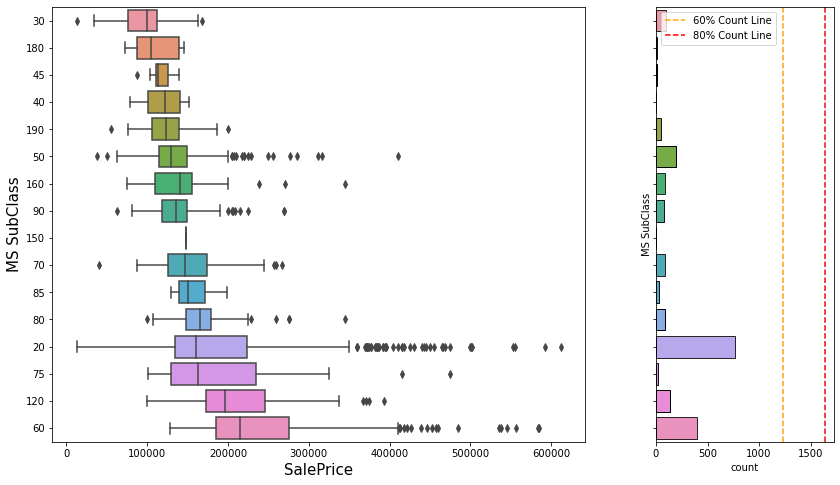

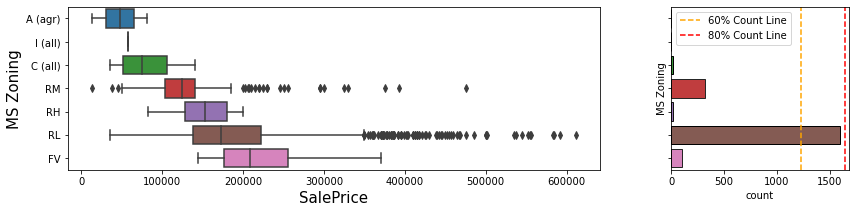

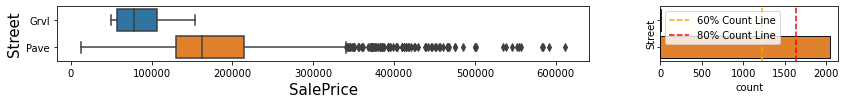

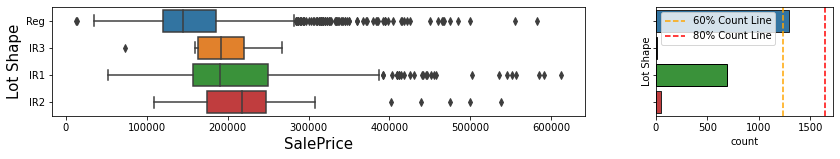

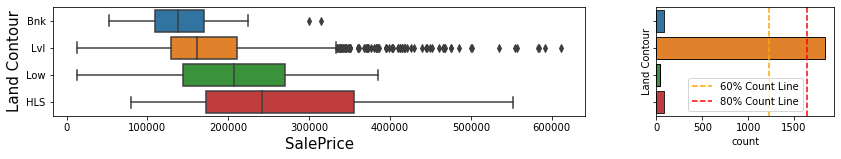

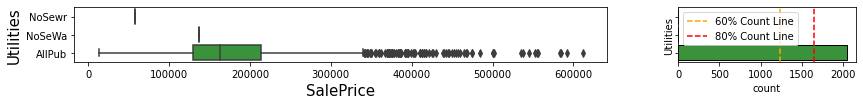

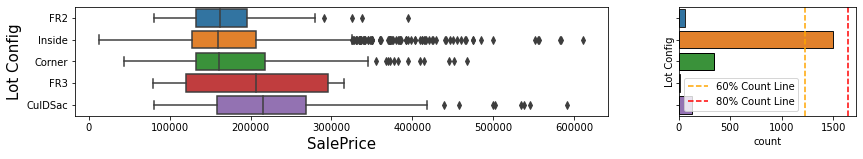

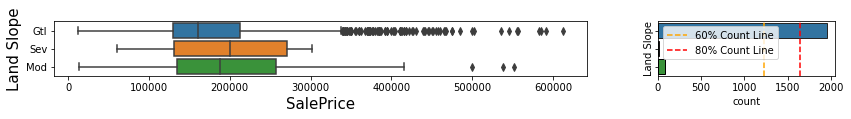

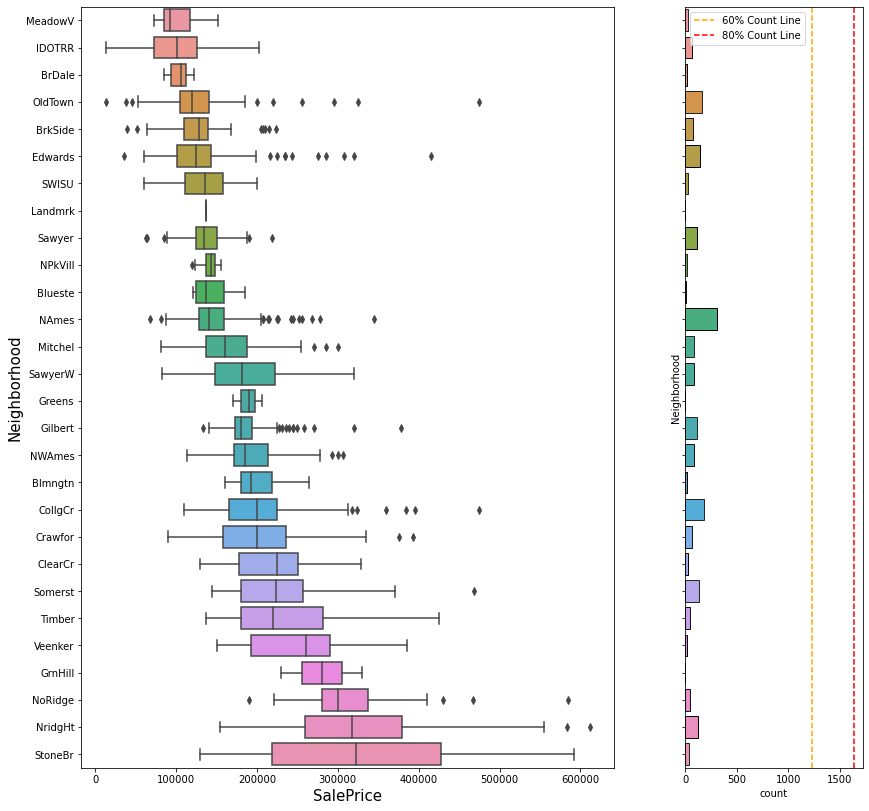

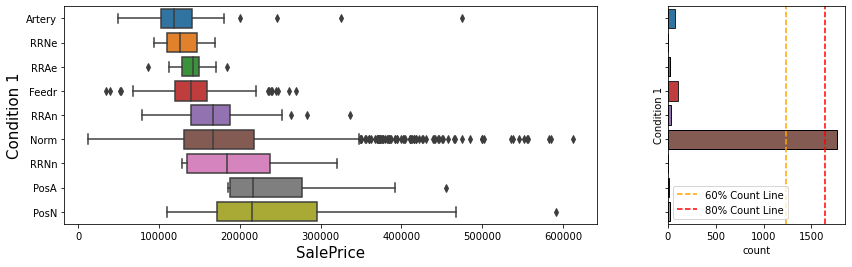

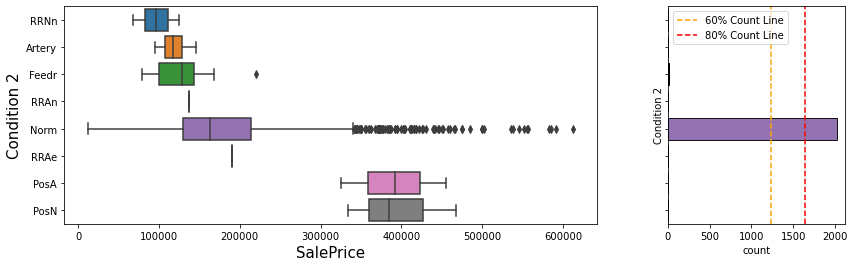

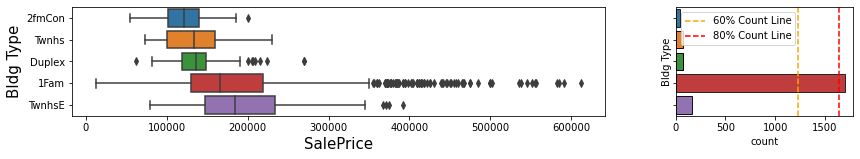

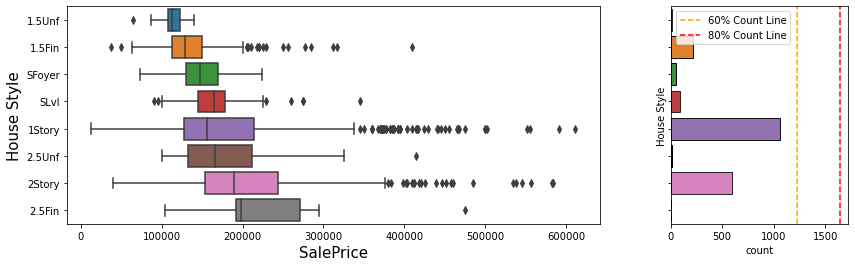

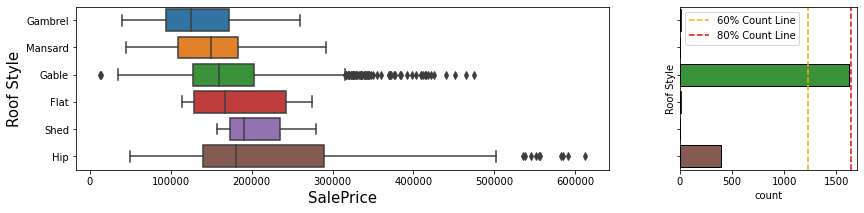

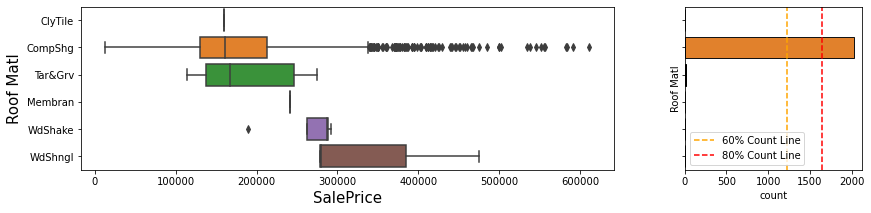

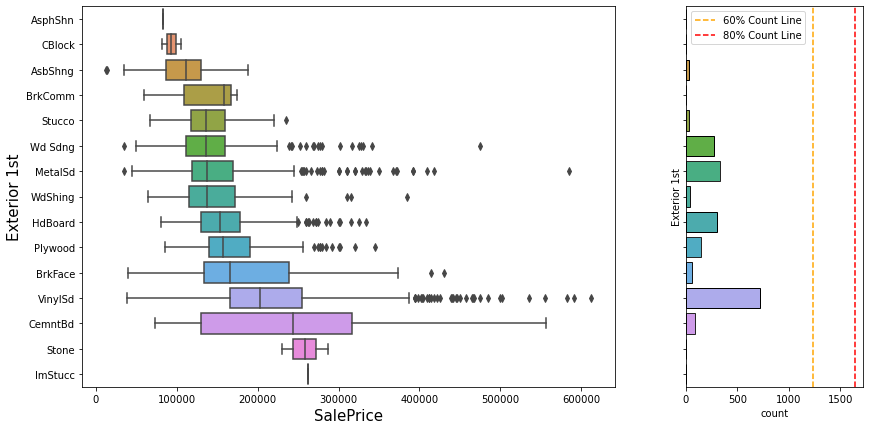

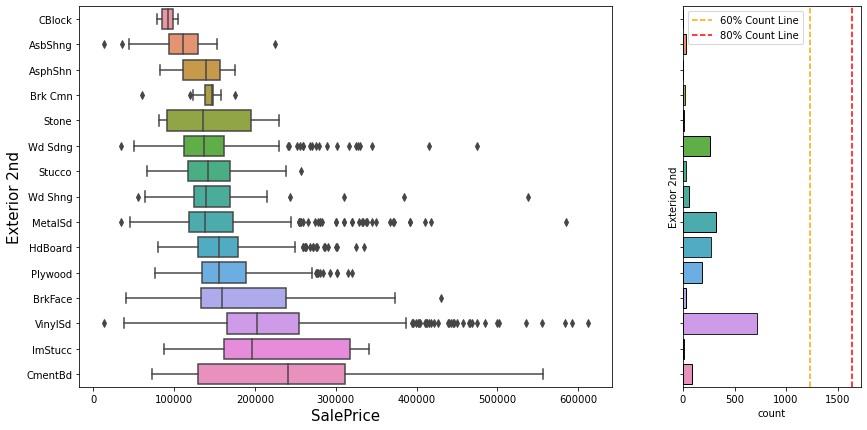

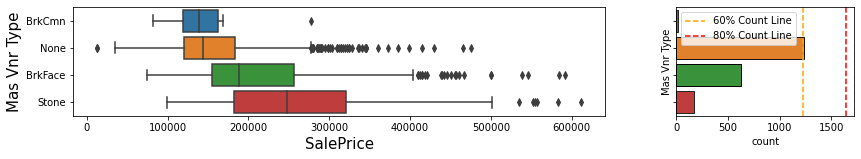

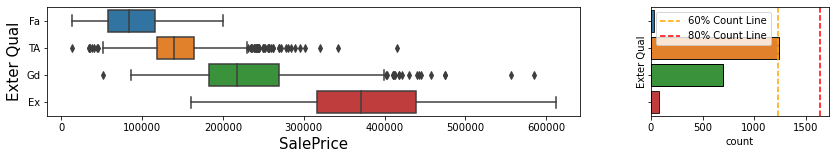

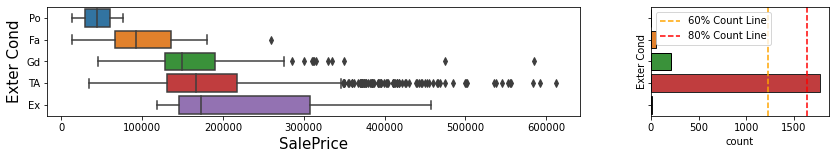

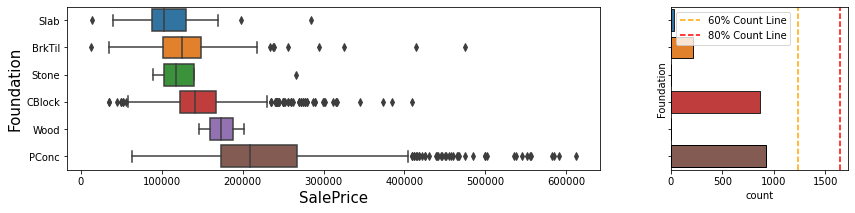

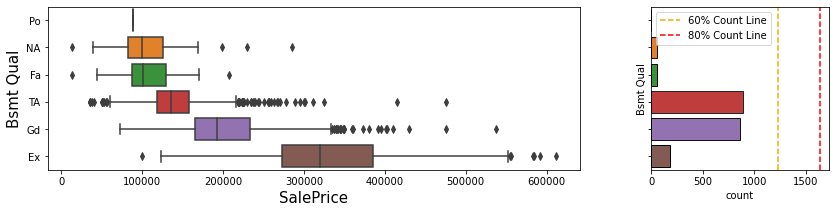

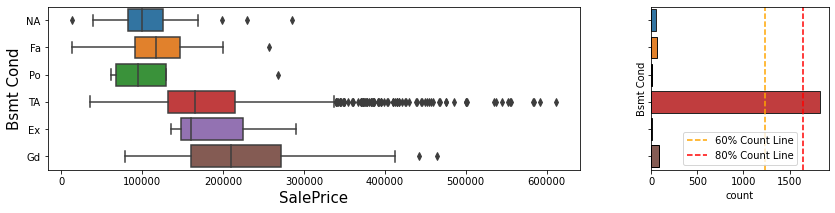

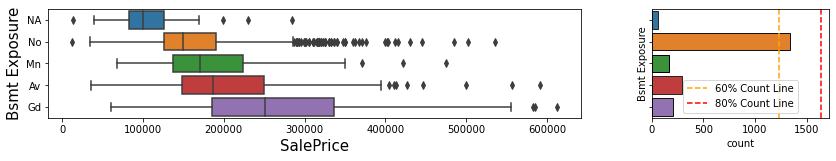

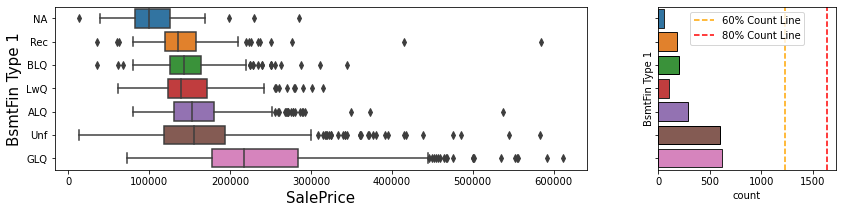

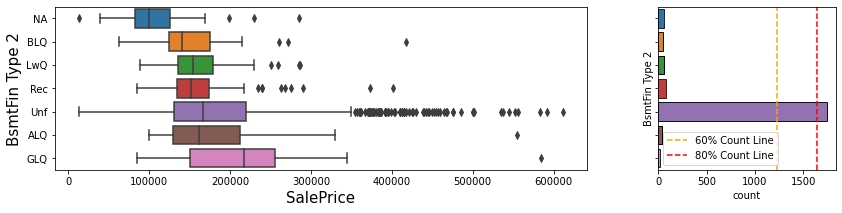

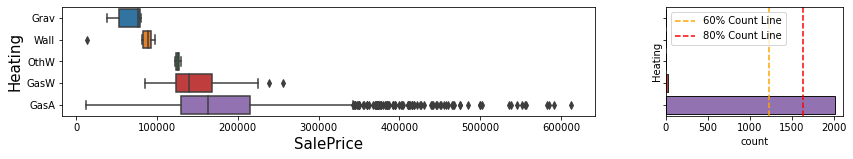

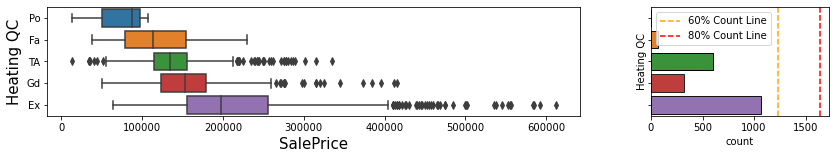

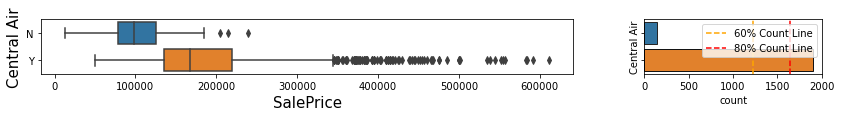

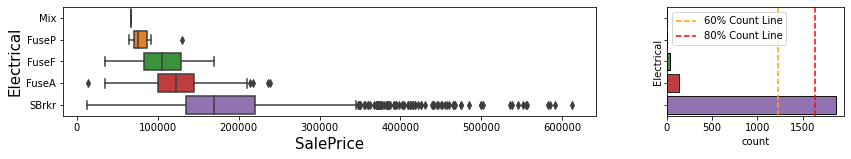

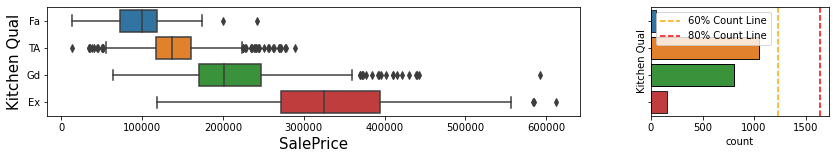

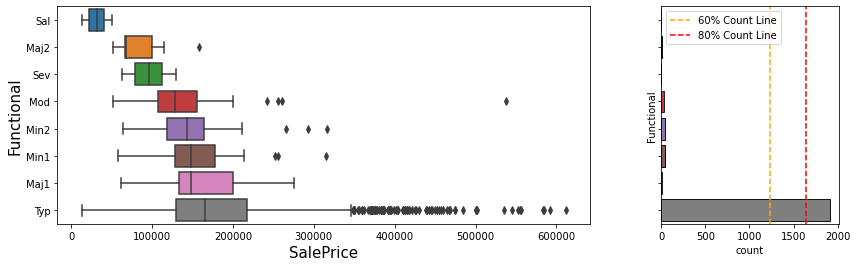

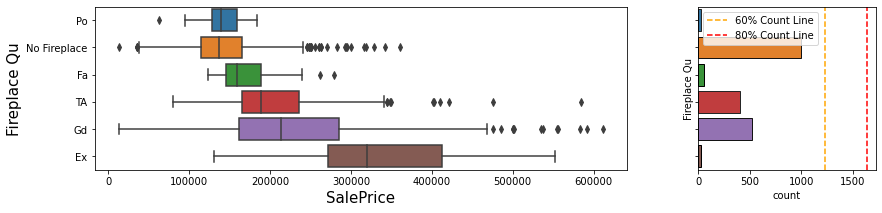

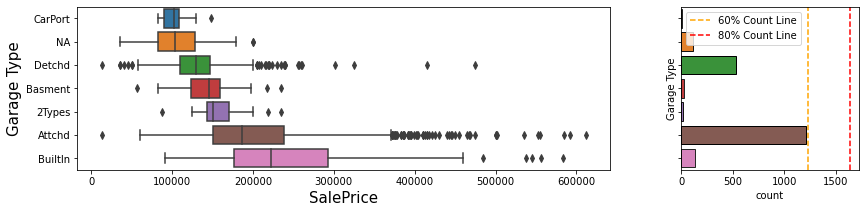

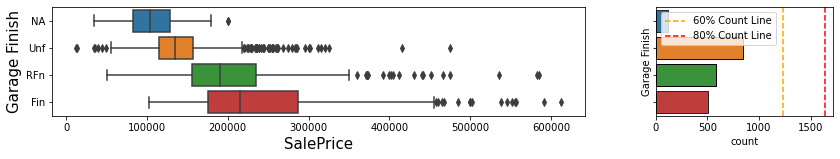

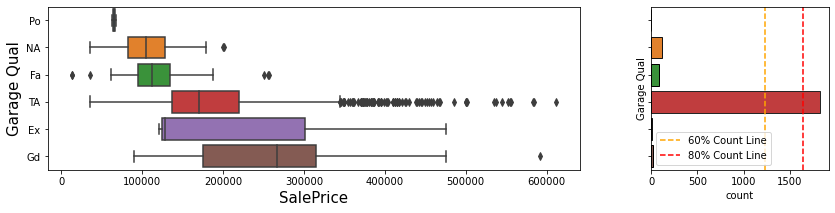

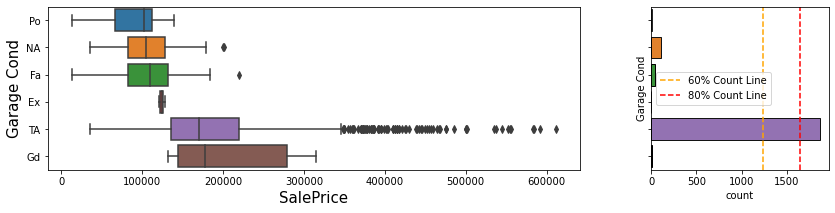

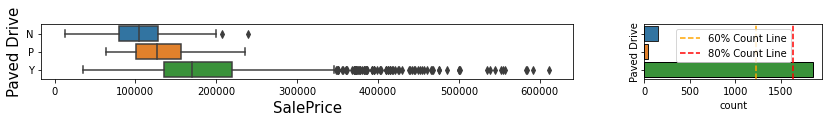

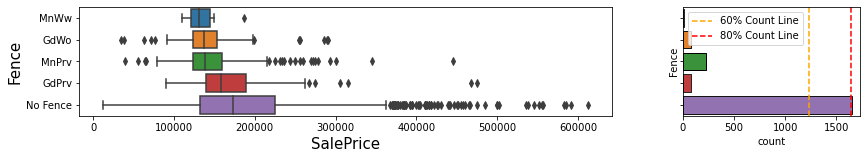

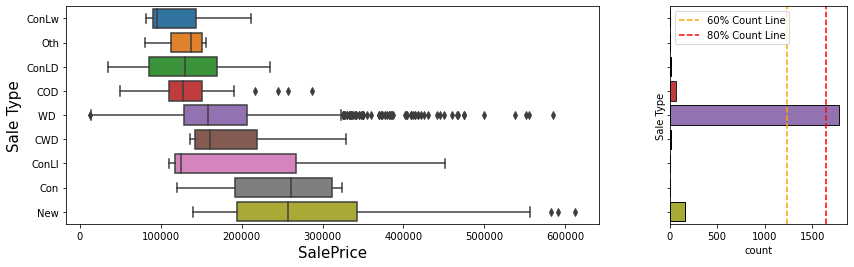

In [66]:
categorical_plotter(ames, cat_features)

**Observations:**
- A few features with significant counts of data within a single category such as 'Condition 2', 'Bldg Type', and 'Roof Matl'. This will likely to not provide any significant information to the model.
- A few features with obvious difference in terms of SalePrice between categories with good splitting of data between the categories. These features are 'Exter Qual' and 'Mas Vnr Type'.

## Feature Selection

The original datasets comes with 80 independent variables and 1 target variable (SalePrice). The data cleaning section above reduced it to 77 independent variables. Looking at the data closer, it is sensible to remove ID variable as they are unlikely to help predict any house's SalePrice which leaves us with 76 variables. 

In [67]:
## Remove Id column from ames
ames.drop('Id', axis=1, inplace=True)

At this point, it seems like we have more than sufficient information to predict the data accurately, right? Not so fast. Having too many low quality variables (with little correlation with the actual SalePrice) may introduce **noise** into the model and cause it to **lose prediction accuracy**. In other words, instead of fitting the model to the actual signal, we may actually **fit it to its noise**. Therefore, the objective of this chapter is to eliminate as many low quality variables and leave the high quality variable intact for our model to learn from. 

Broadly speaking, high quality variables are the ones with these criteria:
1. No Majority Counts
 - High quality variable has to be able to divide datapoints to at least two or more categories with no one category having majority counts. Variable which does not have this quality will not provide additional information to the model to learn from. 
2. Having no high collinearity with other variable(s)
 - Correlation between variables will be used to find variable with high correlation with other variable. High correlated variables will be removed (only one will be retained for information retainment).
3. Spread the SalePrice into a distinct group/ pattern
 - For categorical variables, boxplot will be employed to find variable with low distinction per group
 - For numerical variables, correlation against the SalePrice feature will be used to perform the selection. Variable with low correlation will be removed. 

### Remove Features with Majority Counts

In [68]:
## We will remove column below as they contains a category with > majority threshold data counts
## hence does not divide the data sufficiently

col_maj = [col for col in ames.columns if (ames[col].value_counts().max())>=(len(ames)* maj_threshold)]
np.array(col_maj)

array(['MS Zoning', 'Street', 'Land Contour', 'Utilities', 'Lot Config',
       'Land Slope', 'Condition 1', 'Condition 2', 'Bldg Type',
       'Roof Style', 'Roof Matl', 'Exter Cond', 'Bsmt Cond',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Heating', 'Central Air',
       'Electrical', 'Low Qual Fin SF', 'Bsmt Half Bath', 'Kitchen AbvGr',
       'Functional', 'Garage Qual', 'Garage Cond', 'Paved Drive',
       'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area',
       'Fence', 'Misc Val', 'Sale Type'], dtype='<U15')

In [69]:
ames.drop(labels=col_maj, axis=1, inplace=True)

### Remove Features with High Collinearity

#### Non-Categorical Features

The correlation between two continuous variable can be easily computed based on Pearson's correlation. This correlation will provide us the insight on the correlation strength and direction in the form of easy to understand range [-1, 1] ([source](https://www.statisticssolutions.com/pearsons-correlation-coefficient/#:~:text=Pearson's%20correlation%20coefficient%20is%20the,on%20the%20method%20of%20covariance.)). Therefore, parameters with high correlation to one another can be removed from the list as it may disturb the linear model accuracy.

In [70]:
# Create dataframe consisting only numerical features

non_categorical_df = ames.loc[:,~ames.columns.isin(cat_features)].copy()
np.array(non_categorical_df.columns)

array(['index', 'PID', 'Lot Frontage', 'Lot Area', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'BsmtFin SF 1', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF',
       '2nd Flr SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'TotRms AbvGrd', 'Fireplaces',
       'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF',
       'Mo Sold', 'Yr Sold', 'SalePrice'], dtype=object)

In [71]:
# Build correlation matrix and sort the highest pairwise correlation to remove

corr_matrix = non_categorical_df.corr().abs()

corr_sum = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1) ## Create a triangle matrix with only upper part shows 1
    .astype(np.bool)                         ## Convert 1 to True and 0 to False
).stack().sort_values(ascending=False)       ## Stack convert it to two columns pair and sort it based on value

In [72]:
# Retain one variable from the pair with a higher correlation to target variable
# This step is to generate the list of variable to remove

col_multicol = list()
for i, corr_val in enumerate(corr_sum):
    if corr_val > mul_threshold_init:                      # mul_threshold is the chosen constant as max pairwise correlation value
        v1 = corr_sum.index[i][0]
        v2 = corr_sum.index[i][1]
        v1_y_corr = ames[[v1,'SalePrice']].corr().iloc[1,0]
        v2_y_corr = ames[[v2,'SalePrice']].corr().iloc[1,0]
        if v1_y_corr >= v2_y_corr:
            col_multicol.append(v2)
        else:
            col_multicol.append(v1)
            
np.array(col_multicol)

array([], dtype=float64)

In [73]:
# Drop corresponding columns

non_categorical_df.drop(columns=col_multicol, axis=1, inplace=True)

#### Categorical features

On the other hand, Pearson's correlation is unable to capture correlation on categorical features. Therefore, we need to use Cramer's V correlation ([source](https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365#:~:text=Correlation%20between%20a%20continuous%20and%20categorical%20variable&text=There%20are%20three%20big%2Dpicture,and%20Kruskal%20Wallis%20H%20Test.)). Similarly to Pearson's correlation, Cramer's V correlation provides the strength and direction of correlation in terms of value range between [-1, 1]. However, for bigger dataset, standard Cramer's V computation tend to overestimate the correlation value ([source](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V)). Therefore, a bias correction formula is used to verify the correlation between two features.

In [74]:
# To obtain the strength of correlation between two categorical variables
# Create a function to compute Cramer's V correlation based on Wikipedia page on Cramer's V
# link: https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

def cramers_v(df, var1, var2):
    x1 = df[var1]
    x2 = df[var2]
    crosstab = pd.crosstab(x1, x2)           # crosstab build matrix with the counts of data per category 
                                             # this step also converts categorical features to numerical
    chi2 = chi2_contingency(crosstab)[0]     # obtain chi2 value using scipy.stats
    n = crosstab.sum().sum()                 # find number of total data (should be equals to number of row)
    r, k = crosstab.shape                    # get the r, k    
    phi2 = chi2/n                            
    
    # to account for the size of data
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))  
    rcorr = r-((r-1)**2)/(n-1)               
    kcorr = k-((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [75]:
# Construct correlation dataframe for categorical features

cat_features_after_majdrop = [col for col in cat_features if col not in col_maj]

## Construct dataframe holder
categorical_corr = pd.DataFrame(columns=['var1','var2','corr'])   

## Construct a permutation of all categorical variables
categorical_iter = list(itertools.combinations(cat_features_after_majdrop,2))   
for var1, var2 in categorical_iter:
    new_corr = pd.DataFrame(data = {'var1' : [var1],
                                    'var2' : [var2],
                                    'corr' : [cramers_v(ames, var1, var2)]})
    categorical_corr = categorical_corr.append(new_corr)
categorical_corr.reset_index(inplace=True, drop=True)
categorical_corr.sort_values(by='corr', ascending=False, inplace=True)

In [76]:
categorical_corr.head(20)

,var1,var2,corr
2,MS SubClass,House Style,0.837983
58,Exterior 1st,Exterior 2nd,0.715956
135,Garage Type,Garage Finish,0.689669
96,Exter Qual,Kitchen Qual,0.552873
108,Bsmt Qual,Bsmt Exposure,0.539307
115,Bsmt Exposure,BsmtFin Type 1,0.528991
109,Bsmt Qual,BsmtFin Type 1,0.521020
100,Foundation,Bsmt Qual,0.512093
35,Neighborhood,Exter Qual,0.501359
92,Exter Qual,Bsmt Qual,0.474205


Based on [Exploratory Data Analysis](#Exploratory-Data-Analysis), a few outstanding features which able to split the SalePrice apart are selected. 

<br>It is important to note also that after a few iterations, it was observed that the model constantly underpredicting higher priced houses (SalePrice > $350,000). Therefore, a new feature which specifically target the more expensive houses are created to improve the model. 

In [77]:
# Function to predict expensive houses is set up based on 'Gr Liv Area', 'Kitchen Qual', 'Exter Qual' and 'Bsmt Qual'

def expensive(df, liv_area, ktch_qual, extr_qual, bsmt_qual):      
    if (df[liv_area]> 2000) & ((df[ktch_qual]=='Ex') | (df[extr_qual]=='Ex') | (df[bsmt_qual]=='Ex')):
        return 'yes'
    else:
        return 'no'
    
# Assign the new parameter to 'likely_exp' column in ames dataframe
ames['likely_exp'] = ames.apply(lambda x: expensive(x,
                                                    'Gr Liv Area',
                                                   'Kitchen Qual',
                                                   'Exter Qual',
                                                   'Bsmt Qual'), axis=1)

In [78]:
# Based on the multicolinearity obtained from Cramer's V correlation and EDA section, 
# a few categorical features are selected
 
selected_cat_features = ['MS SubClass', 'Neighborhood',
                         'Bsmt Qual', 'Mas Vnr Type', 'likely_exp']

## Preprocessing

Before we feed the selected categorical features to the linear model, we need to convert them into numerical variables. We have two options here, one is to one hot encoding them or to retain the order using ordinal variable. For a start we will try to use Ordinal Encoding first as the baseline and uses each category's average SalePrice value to provide them with *pseudo*-order.

In [79]:
# Create an order in which OrdinalEncoder will be performed
# The basis is to create a pseudo-order even for nominal groups based on the average SalePrice per category

order_list = list()
for col in selected_cat_features:
    order = list(ames.groupby(col)[['SalePrice']].mean().sort_values(by='SalePrice').index)
    order_list.append(order)
np.array(order_list, dtype='object')

array([list(['30', '180', '45', '40', '190', '50', '160', '90', '150', '70', '85', '80', '20', '75', '120', '60']),
       list(['MeadowV', 'IDOTRR', 'BrDale', 'OldTown', 'BrkSide', 'Edwards', 'SWISU', 'Landmrk', 'Sawyer', 'NPkVill', 'Blueste', 'NAmes', 'Mitchel', 'SawyerW', 'Greens', 'Gilbert', 'NWAmes', 'Blmngtn', 'CollgCr', 'Crawfor', 'ClearCr', 'Somerst', 'Timber', 'Veenker', 'GrnHill', 'NoRidge', 'NridgHt', 'StoneBr']),
       list(['Po', 'NA', 'Fa', 'TA', 'Gd', 'Ex']),
       list(['BrkCmn', 'None', 'BrkFace', 'Stone']), list(['no', 'yes'])],
      dtype=object)

In [80]:
# Perform OrdinalEncoder on all categorical features and replace original values with Ordinal variables

enc = OrdinalEncoder(categories=order_list, handle_unknown='use_encoded_value', unknown_value=-1)
ames[selected_cat_features] = enc.fit_transform(ames[selected_cat_features])   # Retain only numerical features for correlation check

In [81]:
selected_cat_df = ames[selected_cat_features]

np.array(selected_cat_df.columns)

array(['MS SubClass', 'Neighborhood', 'Bsmt Qual', 'Mas Vnr Type',
       'likely_exp'], dtype=object)

### Dependent and Independent Variables Splitting

Before we perform polynomial feature analysis on the numerical features, we shall remove target variable as to not leak to the rest of the features.

Note that section [2.5.1](#Dependent-and-Independent-Variables-Splitting), [2.5.2](#Polynomial-Features), [2.5.3](#High-Correlation-to-Target-Variable), [2.5.4](#Remove-Variables-with-High-Pairwise-Correlation) are meant only for numerical (non-categorical) features.

In [82]:
# Split data into independent (X) and dependent (y) variables

X = non_categorical_df.loc[:,non_categorical_df.columns!='SalePrice'].copy()
y = non_categorical_df['SalePrice']

In [83]:
# Remove index column

X.drop(columns='index', axis=1, inplace=True)

### Polynomial Features

#### Additional Features

As PolynomialFeatures from sklearn does not come with logarithmic and root relation, we will develop our own variables before PolynomialFeature handles the rest. 

##### Root term before polynomial features

In [84]:
# For root
## Create a dataframe to temporary house the root terms
if root_variable: 
    X_col_ori = X.columns
    X_root = pd.DataFrame()
    X_root = X.copy()

## If root_after_pf is False, it means that we will generate the root terms before polynomial feature generation
## in the next step, therefore, the subsequent code will be performed.
if (root_variable) & (not root_after_pf):
    for X_col in X_col_ori:
        # Change column name to show that it is root term of specific feature
        new_col_name = X_col + "_root"      
        X_root.rename(columns={X_col:new_col_name}, inplace=True)
        
    # Apply root for each term
    X_root = X_root.apply(np.sqrt)

    # Combine the root dataframe to the original dataframe
    X = pd.concat([X,X_root], axis=1, join='inner')

##### Log term before polynomial features

In [85]:
# For log
## Create a dataframe to temporary house the log terms
if log_variable:
    X_col_ori = X.columns
    X_log = pd.DataFrame()
    X_log = X.copy()

## If log_after_pf is False, it means that we will generate the log terms before polynomial feature generation
## in the next step, therefore, the subsequent code will be performed.
if (log_variable) & (not log_after_pf): 
    col_drop_log = list()
    for X_col in X_col_ori:
        # Change column name to show that it is root term of specific feature
        new_col_name = X_col + "_log"
        
        # This code is to ensure no '0' value in the column before logarithmic operation is performed
        ## Column with 0 value will be skipped
        if (X_log[X_col] == 0).any():
            col_drop_log.append(X_col)
            X_log.drop(columns=X_col, inplace=True)
        else:
            X_log.rename(columns={X_col:new_col_name}, inplace=True)

    # Apply root for each term
    X_log = X_log.apply(np.log)
    
    # Combine the root dataframe to the original dataframe
    X = pd.concat([X,X_log], axis=1, join='inner')

##### Application of polynomial features

In [86]:
# This section of code is to perform the polynomial feature generation

if poly_on:
    # Instantiate polynomial features instance and fit_transform the independent variable
    pf = PolynomialFeatures(degree=2, include_bias=False)
    X_pf = pf.fit_transform(X)

    # Generate dataframe consisting of the result of polynomial feature
    X_pf_names = pf.get_feature_names(X.columns)
    X_pf_df = pd.DataFrame(X_pf, columns=X_pf_names)
else:
    X_pf_df= X.copy()

##### Root term after polynomial features

In [87]:
# For root
if root_variable & root_after_pf:
    # Change column name to show that it is root term of specific feature
    for X_col in X_col_ori:
        new_col_name = X_col + "_root"
        X_root.rename(columns={X_col:new_col_name}, inplace=True)
    
    # Apply the root term for each term
    X_root = X_root.apply(np.sqrt)

    # Combine the original dataframe with the root term dataframe
    X_pf_df = pd.concat([X_pf_df,X_root], axis=1, join='inner')

    # Replace nan values resulted in unfiltered negative value which is processed by np.sqrt function
    X_pf_df.fillna(value=X.mean(), inplace=True);

##### Log term after polynomial features

In [88]:
# For log
if log_variable & log_after_pf: 
    # Change column name to show that it is log term of specific feature
    for X_col in X_col_ori:
        new_col_name = X_col + "_log"
        if (X_log[X_col] == 0).any():
            X_log.drop(columns=X_col, inplace=True)
        else:
            X_log.rename(columns={X_col:new_col_name}, inplace=True)

    # Apply the log term for each term
    X_log = X_log.apply(np.log)
    
    # Combine the original dataframe with the log term dataframe
    X_pf_df = pd.concat([X_pf_df,X_log], axis=1, join='inner')

    # Replace nan values resulted in 0 value which is processed by np.log function
    X_pf_df.fillna(value=X.mean(), inplace=True);

### High Correlation to Target Variable

At this point, we already formed up the complete set of features with their corresponding log, root, quadratic and interaction terms. In this project, we will try to limit the number of training features to total 30 to prevent overfitting to the training data. Therefore, we will rank the correlation of each term with the SalePrice to select top features to train the prediction model.

In [89]:
# Choose variables with high correlation with SalePrice (y)

# Create a DataFrame place holder to retain variables correlation
corr_df = pd.DataFrame(columns=['var', 'corr with y'])   

for i, col in enumerate(X_pf_df.columns):
    try:
        # Compute absolute correlation on variable to SalePrice
        corr = abs(X_pf_df.iloc[:,i].corr(y))          
    except:
        print(col)
        
    # Variable name
    var = X_pf_df.columns[i]
    
    # Create dataframe to be combine with the place holder
    new = pd.DataFrame([[var, corr]],columns=['var', 'corr with y'])  
    
    # Combine the new df with the place holder
    corr_df = pd.concat([corr_df,new], ignore_index=True)      
    
# Choose top variable with the highest correlation with SalePrice
X_pf_corr = corr_df.sort_values(by='corr with y', ascending=False)

In [90]:
np.array(X_pf_corr['var'])

array(['Overall Qual Gr Liv Area', 'Overall Qual^2',
       'Overall Qual Garage Cars', 'Overall Qual Garage Area',
       'Overall Qual Year Built', 'Overall Qual Year Remod/Add',
       'Overall Qual', 'Overall Qual Yr Sold',
       'Overall Qual TotRms AbvGrd', 'Gr Liv Area Garage Cars',
       'Overall Qual 1st Flr SF', 'Overall Qual Total Bsmt SF',
       'Total Bsmt SF Garage Cars', '1st Flr SF Garage Cars',
       'Overall Qual Full Bath', 'Gr Liv Area Garage Area',
       'Full Bath Garage Area', 'TotRms AbvGrd Garage Cars',
       'TotRms AbvGrd Garage Area', 'Year Built Gr Liv Area',
       'Full Bath Garage Cars', 'Total Bsmt SF Full Bath',
       'Year Remod/Add Gr Liv Area', '1st Flr SF Garage Area',
       'Gr Liv Area', 'Gr Liv Area Yr Sold', 'Total Bsmt SF Garage Area',
       'Garage Cars Garage Area', '1st Flr SF Full Bath',
       'Gr Liv Area Full Bath', 'Lot Frontage Overall Qual',
       'Garage Cars^2', 'Year Built Garage Area',
       'Year Built Garage Cars', '

### Remove Variables with High Pairwise Correlation

However, high correlation to the target variable does not guarantee a set of features to sufficiently train the model. This is because, there maybe features within the selected set which share high pairwise correlation to one another. It will be bad for the model for two reasons, **one** as multicollinearity undermines the statistical significant of the predictor feature ([source](https://link.springer.com/chapter/10.1007/978-0-585-25657-3_37#:~:text=Multicollinearity%20is%20a%20problem%20because,coefficient%20will%20be%20statistically%20significant.)) and **second** as high pairwise features are likely to be in the top few selected features and taken up space for other important features which contain important information about the dataset.

Therefore, we will only select features with high correlation with the SalePrice but does not have high pairwise correlation to one another.

In [91]:
## This code will obtain the pairwise correlation between the new variables to avoid multicollinearity.

new_vars = X_pf_corr['var']

## Similarly with removal of original variables to prevent multicollinearity
## We will retain one variable from the pair with a higher correlation to target variable

## Build correlation matrix and sort the highest pairwise correlation to remove

new_corr_matrix = X_pf_df[new_vars].corr().abs()

new_corr_summary = new_corr_matrix.where(
    np.triu(np.ones(new_corr_matrix.shape), k=1) ## Create a triangle matrix with only upper part shows 1
    .astype(np.bool)                         ## Convert 1 to True and 0 to False
).stack().sort_values(ascending=False)       ## Stack convert it to two columns pair and sort it based on value

In [92]:
print("A few of correlation summary:")
new_corr_summary.head()

A few of correlation summary:


Yr Sold^2              Yr Sold               1.0
Mas Vnr Area Yr Sold   Mas Vnr Area          1.0
Open Porch SF Yr Sold  Open Porch SF         1.0
Half Bath              Half Bath Yr Sold     1.0
2nd Flr SF             2nd Flr SF Yr Sold    1.0
dtype: float64

In [93]:
print(f"Number of pairwise correlation being computed: {len(new_corr_summary)}")

Number of pairwise correlation being computed: 70876


In [94]:
## This step is to generate a list of new variable to remove due to high pairwise correlation

remove_list = list()
for i, corr_val in enumerate(new_corr_summary):
    if corr_val > mul_threshold_final:                       ##  set a constant as max pairwise correlation value
        v1 = new_corr_summary.index[i][0]    ## Obtain new variable 1 name
        v2 = new_corr_summary.index[i][1]    ## Obtain new variable 2 name
        v1_y_corr = X_pf_corr[X_pf_corr['var'] == v1].iloc[0,1]  ## Obtain new variable 1 correlation to SalePrice
        v2_y_corr = X_pf_corr[X_pf_corr['var'] == v2].iloc[0,1]  ## Obtain new variable 2 correlation to SalePric
        if v1_y_corr >= v2_y_corr:
            remove_list.append(v2) 
        else:
            remove_list.append(v1)
            
print("Number of correlation to remove: {len(np.array(remove_list))}")

Number of correlation to remove: {len(np.array(remove_list))}


In [95]:
# Select numerical features which does not have high pairwise correlation
# The number of numerical feature can be adjusted in high level parameter 'noncat_count'

chosen_noncat_var = X_pf_corr[~X_pf_corr['var'].isin(remove_list)].head(noncat_count)['var']
np.array(chosen_noncat_var)

array(['Overall Qual Gr Liv Area', 'Overall Qual^2',
       'Overall Qual Garage Cars', 'Gr Liv Area Garage Cars',
       'Overall Qual 1st Flr SF', 'Total Bsmt SF Garage Cars',
       'Overall Qual Full Bath', 'Full Bath Garage Area',
       'Total Bsmt SF Full Bath', 'Lot Frontage Overall Qual',
       'Total Bsmt SF TotRms AbvGrd', 'Fireplaces Garage Cars',
       'Lot Frontage Garage Cars', '1st Flr SF Gr Liv Area',
       'Year Built Year Remod/Add', 'Mas Vnr Area Garage Cars',
       'Overall Qual Bedroom AbvGr', 'Lot Frontage Full Bath',
       'Bedroom AbvGr Garage Area', 'Overall Qual Overall Cond',
       'BsmtFin SF 1 Garage Cars', 'Overall Cond Gr Liv Area',
       'Total Bsmt SF Fireplaces', 'Year Remod/Add^2',
       'Lot Frontage Gr Liv Area'], dtype=object)

### Combine Back Categorical and Numerical Features

In [96]:
# Merge back categorical and numerical features into a single dataframe

Xwhole_noncat = X_pf_df[chosen_noncat_var]
Xwhole = pd.concat([Xwhole_noncat, selected_cat_df], axis=1, join='inner')

Once the top 30 variables are selected, we will scale the variable so that we can train our linear regression model. However, we will split the dataset into train and validation data to ensure we have 'unseen' data to compare with linear regression models.

#### Split Data into Training and Validation Set

In [97]:
## Split data into train and validation set to pick the best regularization linear regression model

Xtrain, Xval, ytrain, yval = train_test_split(Xwhole, y, test_size=0.2, random_state=0)

#### Scaling

In [98]:
# Split categorical and non-categorical (numerical) as only numerical feature gets standard scaled

Xtrain_cat = Xtrain[selected_cat_features]
Xtrain_noncat = Xtrain.loc[:, ~Xtrain.columns.isin(cat_features)]

Xval_cat = Xval[selected_cat_features]
Xval_noncat = Xval.loc[:, ~Xval.columns.isin(cat_features)]

In [99]:
# Reset the index of categorical feature as index becomes jumbled up after train test split

Xtrain_cat.reset_index(inplace=True, drop=True)
Xval_cat.reset_index(inplace=True, drop=True)

In [100]:
# Scale non-categorical features on both train and validation datasets

ss = StandardScaler()
Xtrain_noncat_s = pd.DataFrame(ss.fit_transform(Xtrain_noncat), columns=Xtrain_noncat.columns)
Xval_noncat_s = pd.DataFrame(ss.transform(Xval_noncat), columns=Xval_noncat.columns)

In [101]:
# Combine categorical and non-categorical features into final train and validation set

Xtrain_s = pd.concat([Xtrain_noncat_s, Xtrain_cat], axis=1, join='inner')
Xval_s = pd.concat([Xval_noncat_s, Xval_cat], axis=1, join='inner')

## Linear Model

At this point, our data is already cleaned, preprocessed and selected based on the feature that are most likely to predict the SalePrice best. Hence, we are ready to start training our linear models. However, as we still ended up with 30 variables, we will further reduce the effect of less significant features by the means of regularizations. There are three types of regularization to be performed, Ridge (L2), Lasso (L1) and Elastic Net (L1-L2). 

The general steps to find the most suitable model for our problem are:
1. Perform cross validation of the model with a range of possible alphas (Ridge, Lasso and Elastic Net) and L1 ratio (only for Elastic Net). The cross validation score will return the best alpha and L1 ratio accordingly.
2. Train the a instance of linear model with the best alpha and L1 ratio from step 1. Training is only done using training dataset.
3. Perform prediction on train and validation set and compute RMSE for each. Values cannot deviate too far as it may signify overfitting.
4. Choose the best model by choose the one with lowest RMSE yet does not have significant variance between variance and training set. 

### Ridge Regression

In [102]:
# Set possible values of alphas as ridge regression hyperparameter
alphas = np.logspace(-10,10,200)

# Instantiate ridge cross validation to find the best hyperparameter
ridge_cv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', store_cv_values=True)
ridge_cv.fit(Xtrain_s, ytrain)
print("Best alpha for Ridge regression: {}". format(ridge_cv.alpha_))

Best alpha for Ridge regression: 14.314589375234815


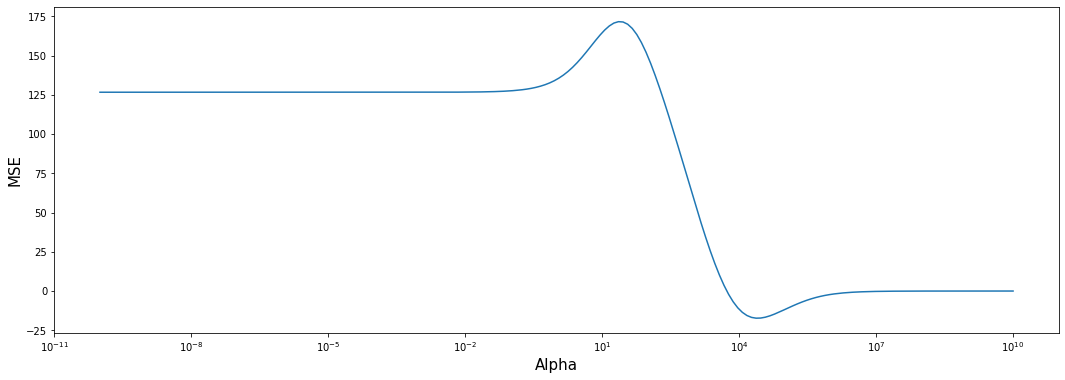

In [103]:
# Plot cross validation RSME with respective alpha to understand if we have reached global minimum
ridge_cv_means = [np.mean(cv_mean) for cv_mean in ridge_cv.cv_values_.T]

fig = plt.figure(figsize=(18,6))
ax = plt.gca()
ax.semilogx(ridge_cv.alphas, ridge_cv_means)

plt.ylabel('MSE')
plt.xlabel('Alpha')

matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12) 

ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15);

In [104]:
# Instantiate Ridge regression model with the best hyperparameter obtained by cross validation step
ridge = Ridge(alpha=ridge_cv.alpha_)

In [105]:
# Create a custom function to print and return RMSE value provided predicted and actual value of SalePrice 
def rmse(preds, y):
    result = round((((preds - y) ** 2).mean() ** (0.5)), 1)
    print(f"RMSE value is: ${result:,}")
    return result

In [106]:
# Train the Ridge model to the training data
r_mod = ridge.fit(Xtrain_s, ytrain)

# RMSE value for train data
print("For training dataset")
r_rmse_train = rmse(r_mod.predict(Xtrain_s), ytrain)

# RMSE value for val data
print("\nFor validation dataset")
preds_r = r_mod.predict(Xval_s)
r_rmse = rmse(preds_r, yval)

For training dataset
RMSE value is: $25,530.4

For validation dataset
RMSE value is: $30,053.3


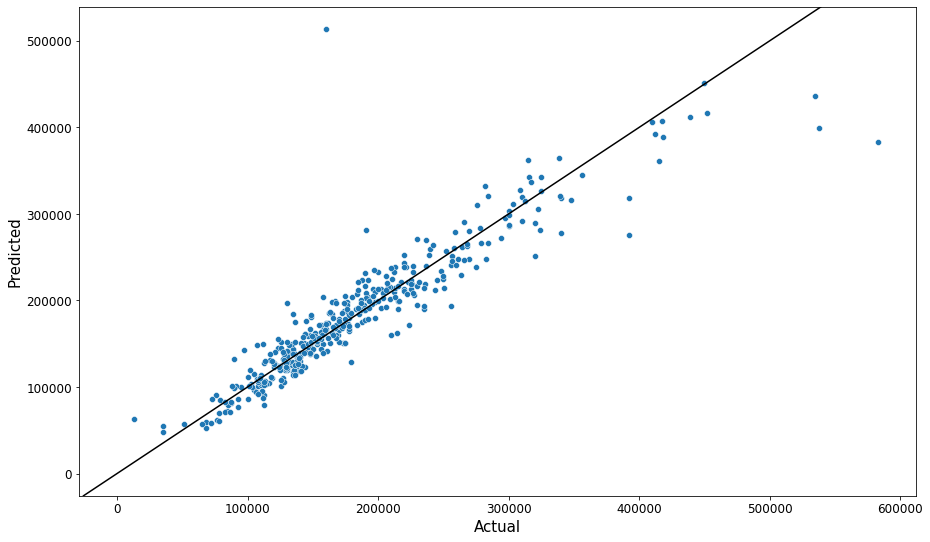

In [107]:
fig,ax = plt.subplots(figsize=(15,9))
sns.scatterplot(
    y=preds_r,
    x=yval,
    ax=ax
)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.axline((0,0),(1,1),color='black')

matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12) 

ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15);

### Lasso Regression

In [108]:
# Instantiate ridge cross validation to find the best hyperparameter
lasso_cv = LassoCV(n_alphas=200)
lasso_cv.fit(Xtrain_s, ytrain)
print("Best alpha for Lasso regression: {}". format(lasso_cv.alpha_))

Best alpha for Lasso regression: 816.2795534717069


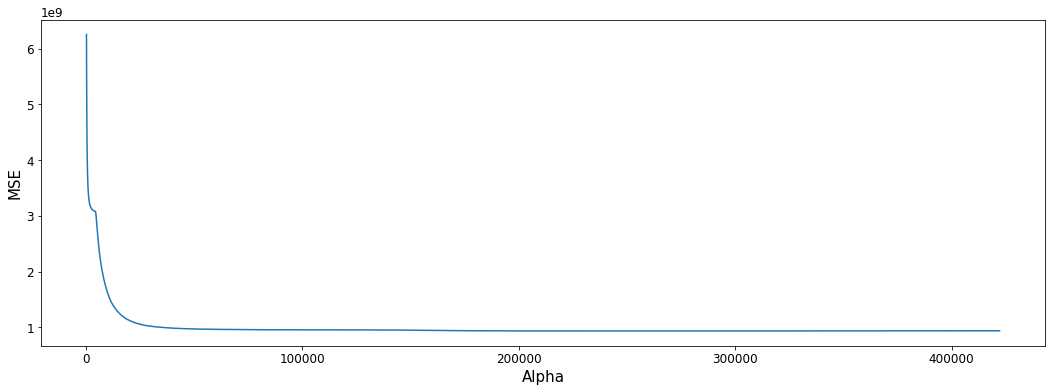

In [109]:
# Plot cross validation RSME with respective alpha to understand if we have reached global minimum
lasso_cv_means = [np.mean(cv_alpha) for cv_alpha in lasso_cv.mse_path_]

fig = plt.figure(figsize=(18,6))
ax = plt.gca()
ax.plot(lasso_cv.alphas_, list(reversed(lasso_cv_means)))

plt.ylabel('MSE')
plt.xlabel('Alpha')

matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12) 

ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15);

In [110]:
# Instantiate Ridge regression model with the best hyperparameter obtained by cross validation step
ridge = Ridge(alpha=ridge_cv.alpha_)

# Train the Ridge model to the training data
r_mod = ridge.fit(Xtrain_s, ytrain)

# RMSE value for train data
print("For training dataset")
r_rmse_train = rmse(r_mod.predict(Xtrain_s), ytrain)

# RMSE value for val data
print("\nFor validation dataset")
preds_r = r_mod.predict(Xval_s)
r_rmse = rmse(preds_r, yval)

For training dataset
RMSE value is: $25,530.4

For validation dataset
RMSE value is: $30,053.3


In [111]:
# Instantiate Lasso regression model with the best hyperparameter obtained by cross validation step
lasso = Lasso(alpha=lasso_cv.alpha_)

# Train the Lasso model to the training data
l_mod = lasso.fit(Xtrain_s, ytrain)

# RMSE value for train data
print("For training dataset")
l_rmse_train = rmse(l_mod.predict(Xtrain_s), ytrain)

# RMSE value for val data
print("\nFor validation dataset")
preds_l = l_mod.predict(Xval_s)
l_rmse = rmse(preds_l, yval)

For training dataset
RMSE value is: $27,175.0

For validation dataset
RMSE value is: $33,424.8


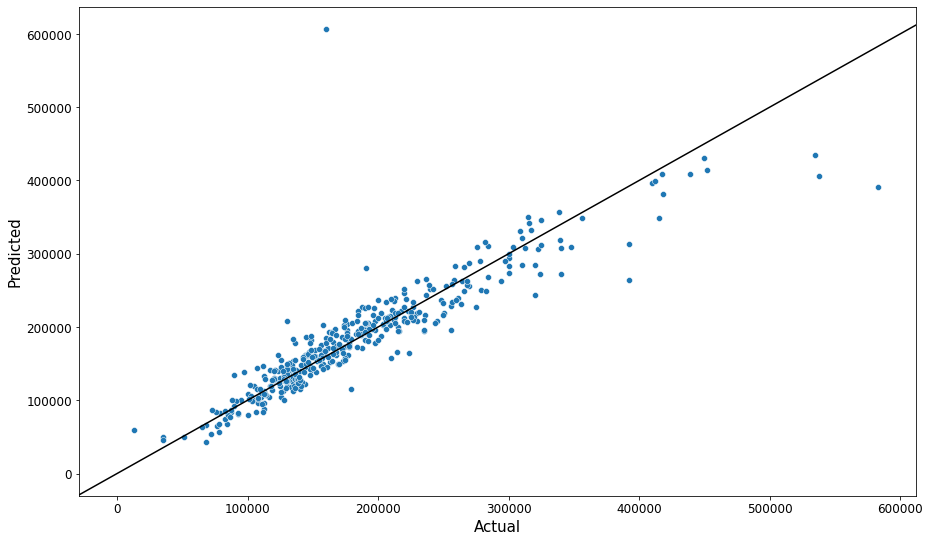

In [140]:
fig, ax = plt.subplots(figsize=(15,9))
sns.scatterplot(
    y=preds_l,
    x=yval,
    ax=ax
)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.axline((0,0),(1,1),color='black')

matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12) 

ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15);

### Elastic Net Regression

In [113]:
# Set L1 ratio value
l1_ratio = np.linspace(0.05, 0.95, 5)

# Instantiate Elastic Net cross validation to find the best hyperparameter
enet_cv = ElasticNetCV(n_alphas=200, l1_ratio=l1_ratio)
enet_cv.fit(Xtrain_s, ytrain)
print("Best alpha for Lasso regression: {}". format(enet_cv.alpha_))

Best alpha for Lasso regression: 444.3069965167978


In [114]:
# Instantiate Elastic Net regression model with the best hyperparameter obtained by cross validation step
enet = ElasticNet(alpha=enet_cv.alpha_, l1_ratio=enet_cv.l1_ratio_)

# Train the Elastic Net model to the training data
e_mod = enet.fit(Xtrain_s, ytrain)

# RMSE value for train data
print("For training dataset")
e_rmse_train = rmse(e_mod.predict(Xtrain_s), ytrain)

# RMSE value for val data
print("\nFor validation dataset")
preds_e = e_mod.predict(Xval_s)
e_rmse = rmse(preds_e, yval)

For training dataset
RMSE value is: $45,187.4

For validation dataset
RMSE value is: $45,476.1


### Summary of Linear Model

In [115]:
print("Based on assumption of: ")
print(" - Majority count threshold: {}%".format(maj_threshold*100))
print(" - Multicollinearity threshold (initial): {}%".format(mul_threshold_init*100))
print(" - Multicollinearity threshold (final): {}%\n".format(mul_threshold_final*100))
print("Results of Linear model predictions are as follows: ")
print("1. Ridge: ")
print(f"Best alpha: {round(ridge_cv.alpha_,1)}")
print(f"RMSE on train set (model fitting on train set): ${r_rmse_train:,}")
print(f"RMSE on val set (model fitting on train set): ${r_rmse:,}\n")
print("2. Lasso: ")
print(f"Best alpha: {round(lasso_cv.alpha_,1)}")
print(f"RMSE on train set (model fitting on train set): ${l_rmse_train:,}")
print(f"RMSE on val set (model fitting on train set): ${l_rmse:,}\n")
print("3. Elastic Net: ")
print(f"Best alpha: {round(enet_cv.alpha_,1)}")
print(f"Best l1_ratio: {round(enet_cv.l1_ratio_,3)}")
print(f"RMSE on train set (model fitting on train set): ${e_rmse_train:,}")
print(f"RMSE on val set (model fitting on train set): ${e_rmse:,}\n\n")
print(f"Total process time: {round(time.process_time(),1)} seconds")

Based on assumption of: 
 - Majority count threshold: 70.0%
 - Multicollinearity threshold (initial): 90.0%
 - Multicollinearity threshold (final): 90.0%

Results of Linear model predictions are as follows: 
1. Ridge: 
Best alpha: 14.3
RMSE on train set (model fitting on train set): $25,530.4
RMSE on val set (model fitting on train set): $30,053.3

2. Lasso: 
Best alpha: 816.3
RMSE on train set (model fitting on train set): $27,175.0
RMSE on val set (model fitting on train set): $33,424.8

3. Elastic Net: 
Best alpha: 444.3
Best l1_ratio: 0.95
RMSE on train set (model fitting on train set): $45,187.4
RMSE on val set (model fitting on train set): $45,476.1


Total process time: 130.3 seconds


## Best Model Training

### Whole Training Dataset Scaling

Once the best model is found, we will need to retrain the model using the entire training set. This way, we can 'load' all information from both training and validation set we split earlier. 

In [116]:
# Instantiate Standard Scaler

ss_final = StandardScaler()

In [117]:
# Split categorical and numerical features so that we can standard scale only the numerical features

Xwhole_cat = Xwhole[selected_cat_features]
Xwhole_noncat = Xwhole.loc[:,~Xwhole.columns.isin(cat_features)].copy()
Xwhole_noncat.drop(columns=['likely_exp'], inplace=True)

In [118]:
# Standard scale the numerical features and form it back into dataframe form

Xwhole_noncat_s = pd.DataFrame(ss_final.fit_transform(Xwhole_noncat), columns=Xwhole_noncat.columns)

In [119]:
# Combine back the categorical and numerical feature into one dataframe for final training

Xwhole_s = pd.concat([Xwhole_noncat_s, Xwhole_cat], axis=1, join='inner')

### Training of Best Model

In [120]:
# Choose the best training model
if (r_rmse<l_rmse) & (r_rmse<e_rmse):
    best_model = Ridge(alpha=ridge_cv.alpha_)
elif (l_rmse<r_rmse) & (l_rmse<e_rmse):
    best_model = Lasso(alpha=lasso_cv.alpha_)
elif (e_rmse<r_rmse) & (e_rmse<l_rmse):
    best_model = ElasticNet(alpha=enet_cv.alpha_, l1_ratio=enet_cv.l1_ratio_)

In [121]:
# Train the model using the whole training dataset
best_model.max_iter=10000
best_model.fit(Xwhole_s, y)

Ridge(alpha=14.314589375234815, max_iter=10000)

## Parameter Setting

We now have all the ingredients we need to perform parametric analysis on different threshold values. This is performed by running the model multiple times and verify the RSME values for training and validation set. As mentioned earlier in [Problem Statement](#Problem-Statement) section, the objective of this project is to find model which able to provide a good balance between bias and variance. Therefore, we would like to reduce the RSME values as much as possible while having no significant difference on RMSE value for training and validation set. 

I will cover the summary of the iteration without pasting all the result value for brevity. Iteration is done with only one parameter being varied while the rest are put to default value.

### Feature Selection Parameters

Default parameters:<br>
- maj_treshold = 90%
- mul_threshold_init = 90%
- mul_threshold_final = 90%
- noncat_count = 25

No polynomial features generation done except for Multicollinearity Threshold Final study.

1. Majority Count Threshold<br>
- Threshold was varied from 70-100%.
- There was no observable difference in terms of model performance. This is sensible because parameter with high majority count is unlikely to have a significant correlation with the target variable. 
- Having said this, the model run time improves from 132s to 124s from 95% to 70% majority threshold, accordingly as lesser parameters are being processed the lower the threshold value is. 

**Best value: 70%** <br>(due to faster run time without compromising model quality)<br>

2. Multicollinearity Threshold Initial (before polynomial feature generation) <br>
- Threshold was varied from 70-100%.
- There was a slight improvement of model performance when threshold is increased (to make the filter more lenient). 
- At 90-100, there is no improvement, however, as threshold does not remove any more features. Therefore, we can conclude that filtering in the early stage before polynomial feature generation is not helping in model performance. 

**Best value: 90%**

3. Multicollinearity Threshold Final (after polynomial feature generation)
- Threshold was varied from 40-80%. 
- The higher the threshold the bigger difference model performance on training and validation set. This is a sign of overfitting to the training data. 
- This pattern is reversed when threshold is reduced (tighter filter) where training and validation performance is equalizing at 40-50% region. 
- At lower than 40% threshold, bias increases for both training and validation dataset. This signifies the pattern of underfitting. 


- **Interestingly**, the best threshold value shifted after interaction polynomial feature are applied. This is because, most of the original features with high pairwise correlation dropped in pecking order in terms of correlation to the SalePrice relative to the quadratic (x1^2) and interaction (x1 * x2) terms.  Finally, it was found that the best multicollinearity threshold is at 90%.

**Best Value: 90%**

### Polynomial Feature Parameters

1. Order 2 Polynomial Feature
- With Polynomial Feature, model improved significantly with both train and validation data improved by about 5,000 in RMSE. This is crucial as the improvement is made with almost no difference in computing time. 

2. Order 3 Polynomial Feature
- On the other hand, 3rd degree Polynomial Feature generation does not bode well with our model. Not only does it increases the train and validation RSME to the level of without Polynomial Feature, it also increases the processing time by almost 80%. 

**Best value: 2nd degree Polynomial Feature**

#### Logarithm Term

1. Introduction of the Logarithm Terms **before** Polynomial Feature Generation
- Introducing Log Terms before Polynomial Feature significantly increases the number of features the multicollinearity checker function needs to verify. This cause the processing time to increases at about 10% while it slightly deteriorates model performance in terms of RMSE.

2. Introduction of the Logarithm Terms **after** Polynomial Feature Generation
- The model performed equally well relative to the model without Logarithm Terms with slight increase in processing time. This is backed up by the fact that none of the Logarithm Terms are being shortlisted to the final features for the model training. 

Therefore, no logarithm terms will be included in the final model.

#### Root Term

1. Introduction of the Square Root Terms **before** Polynomial Feature Generation
- Similarly to introducting of Log term previously, introducing Root term increases processing time and deteriorates RMSE of the best model.

2. Introduction of the Logarithm Terms **after** Polynomial Feature Generation
- Likewise, introducing Log terms after the Polynomial Features does not improve model performance as none of the log terms are included in the final features to train the linear model. 

Therefore, no root terms will be included in the final model.

From section [3.2.1](#Logarithm-Term) and [3.2.2](#Root-Term), it can be seen that there is no root or logarithm terms that is linearly correlated to the final variable. This conclusion is **sensible for a few reasons**:
1. The only type of variable with natural square root dimension are those representing area. Taking the square root of area will provide scale of length for an equivalent house with exact square in dimension. This is unlikely be the case as people are likely to value the house size as well as its actual shape (**not square equivalent of the land**).
2. No natural meaning behind taking the logarithm of any parameter. Therefore, in the remote case of any relation between SalePrice and log of the feature, it is likely to be a coincidence, not natural relationship or correlation. 

### Effect of Outlier

At this point, we already obtained a good parameter for data cleaning and polynomial features. However, we still have a significant RSME variance between training (25,500) and validation data (30,000) which indicates the sign of overfitting. An attempt to reduce this number has been performed with no significant improvement. Subsequently, I took a look again on the dataset and realized there are a few outliers in the dataset with high house area >4000. An attempt to remove the outlier result in a **notable improvement** for both **bias and variance** of the model. 

Currently, the best model (Ridge regression) shows RMSE of 23,600 and 23,700 for training and validation data, accordingly. 

However, removing the outlier from the dataset causes the model to lose information on the actual outlier deviation. I will attempt to submit both models with and without outlier to Kaggle to understand the difference in their performance. 

### Selected Features

In [122]:
# To print selected variables and their respective coefficient

# for feat, coef in zip(Xwhole.columns, best_model.coef_):
#     print("- {} : {}".format(feat, round(coef,1)))

##### Feature Selection using Polynomial Features Application

Based on the best parameter elaborated above, list of features with the highest correlation to the Sale Price and being used for Linear Model training are shown below (format: feature_name : coefficient):<br>
<br> *Numerical features (25)*
- Overall Qual Gr Liv Area : 28509.9
- Overall Qual^2 : 12947.9
- Overall Qual Garage Cars : -10660.2
- Gr Liv Area Garage Cars : 9190.9
- Overall Qual 1st Flr SF : 32726.6
- Total Bsmt SF Garage Cars : 2358.1
- Overall Qual Full Bath : -18118.6
- Full Bath Garage Area : 352.8
- Total Bsmt SF Full Bath : 12359.2
- Lot Frontage Overall Qual : 8108.9
- Total Bsmt SF TotRms AbvGrd : -7735.0
- Fireplaces Garage Cars : 6446.8
- Lot Frontage Garage Cars : 1432.7
- 1st Flr SF Gr Liv Area : -32372.2
- Year Built Year Remod/Add : 6907.5
- Mas Vnr Area Garage Cars : 4626.5
- Overall Qual Bedroom AbvGr : -2663.6
- Lot Frontage Full Bath : 9452.7
- Bedroom AbvGr Garage Area : 2387.0
- Overall Qual Overall Cond : -12909.4
- BsmtFin SF 1 Garage Cars : 9229.1
- Overall Cond Gr Liv Area : 26986.1
- Total Bsmt SF Fireplaces : -1692.1
- Year Remod/Add^2 : 1398.3
- Lot Frontage Gr Liv Area : -19945.9<br><br>


*Categorical features (5)*
- MS SubClass : 72.2
- Neighborhood : 1557.7
- Bsmt Qual : 3253.7
- Mas Vnr Type : -1397.5
- likely_exp : 41479.9

As we can see, all variables included in Numerical features are either interaction or quadratic terms resultant of polynomial feature opeartion. Despite having a good prediction result, it is relatively hard to reason about how individual feature affect the house price. This is what usually called 'Trade-off of explainability and accuracy' ([source](https://medium.com/@erdemkalayci/the-tradeoff-in-machine-learning-accuracy-vs-explainability-fbb13914fde2)). 

To better explain the model, I rerun the code without applying polynomial features. This way, we will obtain less accurate result with better explainability. 

**Feature Selection without Polynomial Feature Application**<br>

In [123]:
# Run the entire notebook without polynomial feature
## Obtain the selected variables and their respective coefficient

var = ['likely_exp', 'Overall Qual', 'Gr Liv Area', 'Bsmt Qual',
       '1st Flr SF', 'Garage Area', 'BsmtFin SF 1', 'Mas Vnr Area',
       'Year Remod/Add', 'Overall Cond', 'Fireplaces', 'Bsmt Full Bath',
       'Lot Area', 'Neighborhood', 'Garage Cars', 'Total Bsmt SF',
       'Wood Deck SF', 'TotRms AbvGrd', 'MS SubClass', 'Open Porch SF',
       'Year Built', 'Mas Vnr Type', 'Mo Sold', 'Bsmt Unf SF',
       'Bedroom AbvGr', '2nd Flr SF', 'PID', 'Half Bath', 'Full Bath',
       'Lot Frontage']

coef = [3.15810937e+04,  2.03987360e+04,  1.65423106e+04,  5.29725147e+03,
        5.23689519e+03,  5.20685079e+03,  4.68488757e+03,  4.09361156e+03,
        3.57977704e+03,  2.92150348e+03,  2.91530519e+03,  2.81803511e+03,
        2.45405687e+03,  2.41728319e+03,  1.80484582e+03,  1.53315585e+03,
        1.30279550e+03,  4.70966907e+02,  5.00083567e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00]

interpret_model = pd.DataFrame({'Variable':var, 'Coefficient':coef}).sort_values(by='Coefficient', 
                                                                                 ascending=False)

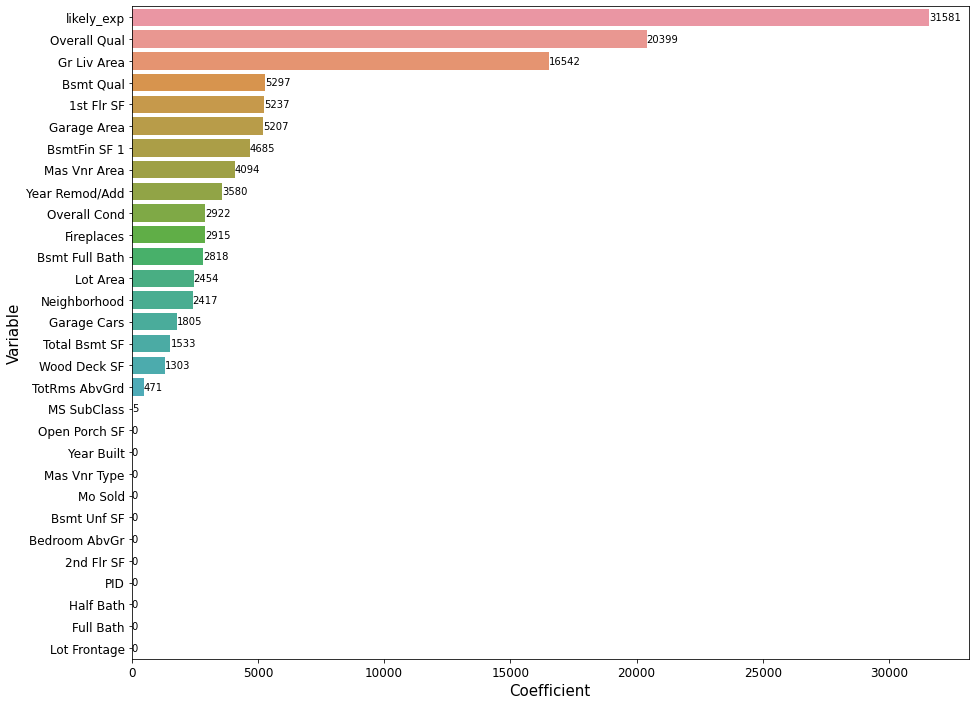

In [124]:
fig, ax = plt.subplots(figsize=(15,12))

g = sns.barplot(
    data=interpret_model,
    x='Coefficient',
    y='Variable',
    orient='h',
    ax=ax,
)
for i in range(len(interpret_model)):
    coef = interpret_model['Coefficient'][i]
    var = interpret_model['Variable'][i]
    g.text(coef, i, round(coef), ha='left', va='center')
    
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15);

<br>*Numerical Features*
- Overall Qual : 20398.7
- Gr Liv Area : 16542.3
- Garage Area : 5206.9
- Garage Cars : 1804.8
- Total Bsmt SF : 1533.2
- 1st Flr SF : 5236.9
- Year Built : 0.0
- Year Remod/Add : 3579.8
- Full Bath : 0.0
- TotRms AbvGrd : 471.0
- Mas Vnr Area : 4093.6
- Fireplaces : 2915.3
- BsmtFin SF 1 : 4684.9
- Open Porch SF : 0.0
- Wood Deck SF : 1302.8
- Lot Frontage : 0.0
- Lot Area : 2454.1
- Bsmt Full Bath : 2818.0
- Half Bath : 0.0
- PID : 0.0
- 2nd Flr SF : 0.0
- Bsmt Unf SF : -0.0
- Bedroom AbvGr : -0.0
- Overall Cond : 2921.5
- Mo Sold : 0.0

*Categorical Features*<br>
- MS SubClass : 5.0
- Neighborhood : 2417.3
- Bsmt Qual : 5297.3
- Mas Vnr Type : 0.0
- likely_exp : 31581.1

In general, all variables included in the final model has positive linear relationship to the house SalePrice. This is likely due to the fact that no natural strong negative correlation for all numerical variable. The top three numerical features which affects SalePrice the most are 'Overall Qual', 'Gr Liv Area', and 'Garage Area'. On Categorical Features, **likely_exp** variable which check the Liv Area of the house and whether the kitchen, exterior or basement quality of the house is excellent, able to push a house price by more than **30,000 USD**. 

It is also important to note that the lasso regression model able to further eliminate the variable to **15 numerical features and 4 categorical features**. 

# Test Set

## Import Test Data

In [125]:
# Load the test dataset and view it

test = pd.read_csv('./datasets/test.csv')
test.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,6,8,1910,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,Fa,Stone,Fa,TA,No,Unf,0,Unf,0,1020,1020,GasA,Gd,N,FuseP,908,1020,0,1928,0,0,2,0,4,2,Fa,9,Typ,0,NaN,Detchd,1910.0,Unf,1,440,Po,Po,Y,0,60,112,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,5,4,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,No,Unf,0,Unf,0,1967,1967,GasA,TA,Y,SBrkr,1967,0,0,1967,0,0,2,0,6,2,TA,10,Typ,0,NaN,Attchd,1977.0,Fin,2,580,TA,TA,Y,170,0,0,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,Gd,Av,GLQ,554,Unf,0,100,654,GasA,Ex,Y,SBrkr,664,832,0,1496,1,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2006.0,RFn,2,426,TA,TA,Y,100,24,0,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,5,6,1923,2006,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Gd,TA,CBlock,TA,TA,No,Unf,0,Unf,0,968,968,GasA,TA,Y,SBrkr,968,0,0,968,0,0,1,0,2,1,TA,5,Typ,0,NaN,Detchd,1935.0,Unf,2,480,Fa,TA,N,0,0,184,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1963,1963,Gable,CompShg,Plywood,Plywood,BrkFace,247.0,TA,TA,CBlock,Gd,TA,No,BLQ,609,Unf,0,785,1394,GasA,Gd,Y,SBrkr,1394,0,0,1394,1,0,1,1,3,1,TA,6,Typ,2,Gd,Attchd,1963.0,RFn,2,514,TA,TA,Y,0,76,0,0,185,0,NaN,NaN,NaN,0,7,2009,WD


## Test Data Cleaning

### Removing Columns

In [126]:
# Extract Id column
test_index = test.loc[:,'Id']
test.drop(columns=cols_10, axis=1, inplace=True)
test.drop(columns='Id', axis=1, inplace=True)

### Data Cleaning

In [127]:
# Impute No Fence in 'Fence' column
test['Fence'].replace(np.NaN,'No Fence', inplace=True)

# Impute No Fireplace in 'Fireplace Qu' column
test['Fireplace Qu'].replace(np.NaN,'No Fireplace',inplace=True)

# Impute Lot Frontage based on Lot Config average
## Create index of missing Lot Frontage (nan)
ind_test = test[test['Lot Frontage'].isnull()][['Lot Frontage','Lot Config']].index

##Replace nan Lot Frontage with average Lot Frontage for each Lot Config
for i in ind_test:
    key = test.iloc[i,:]['Lot Config']
    lot_mean = dic_lf[key]      # dic_lf was created based on train data
    test.at[i,'Lot Frontage'] = lot_mean
    
# Impute None for Masonry Type and 0 for Masonry Area, accordingly
test['Mas Vnr Type'].fillna('None',inplace=True)
test['Mas Vnr Area'].fillna(0, inplace=True)

# To find non-zero area when Masonry is None
## Generate the index of row to amend the value
ind_mas = test[(test['Mas Vnr Type']=='None') & (test['Mas Vnr Area']!= 0)].index

## Replace the value to 0
for i in ind_mas:
    test.at[i,'Mas Vnr Area'] = 0
    
# If all Basement related categories is given as NA, it is assumed that the house has no basement
ind_bsmt = test[(test['Bsmt Qual'].isnull()) |
         (test['Bsmt Cond'].isnull()) |
         (test['Bsmt Exposure'].isnull()) |
         (test['BsmtFin Type 1'].isnull()) |
        (test['BsmtFin Type 2'].isnull())].index

for i in ind_bsmt:
    test.at[i,'Bsmt Qual'] = 'NA'
    test.at[i,'Bsmt Cond'] = 'NA'
    test.at[i,'Bsmt Exposure'] = 'NA'
    test.at[i,'BsmtFin Type 1'] = 'NA'
    test.at[i,'BsmtFin Type 2'] = 'NA'

# If all Basement related categories is given as NA, it is assumed that the house has no garage
ind_gar = test[(test['Garage Type'].isnull()) |
         (test['Garage Finish'].isnull()) |
         (test['Garage Cond'].isnull()) |
         (test['Garage Qual'].isnull())].index

## Impute all null garage data to NA
for i in ind_gar:
    test.at[i,'Garage Type'] = 'NA'
    test.at[i,'Garage Finish'] = 'NA'
    test.at[i,'Garage Qual'] = 'NA'
    test.at[i,'Garage Cond'] = 'NA'

## Drop 'Garage Yr Blt' column
test.drop(columns='Garage Yr Blt', inplace=True)

# Set likely_exp column 
test['likely_exp'] = test.apply(lambda x: expensive(x,
                                                    'Gr Liv Area',
                                                   'Kitchen Qual',
                                                   'Exter Qual',
                                                   'Bsmt Qual'), axis=1)

# Convert MS SubClass column to string datatype
test.loc[:,'MS SubClass'] = test.loc[:,'MS SubClass'].map(lambda x: str(x))

### Remove Features with Majority Count

In [128]:
# Drop columns with majority counts
test.drop(labels=col_maj, axis=1, inplace=True)

### Remove Features with High Collinearity

In [129]:
# Ordinal encode selected categorical features
test[selected_cat_features] = enc.transform(test[selected_cat_features])

# Extract the categorical features into a dataframe
test_categorical_df = test[selected_cat_features]

# Extract the numerical features into a dataframe
test_noncat_df = test.loc[:,~test.columns.isin(cat_features)].copy()
test_noncat_df.drop(columns=['likely_exp'], inplace=True)

In [130]:
# Drop columns with high multicollinearity based on train dataset
test_noncat_df.drop(labels=col_multicol, axis=1, inplace=True)

## Polynomial Features and Scaling

### Additional Features

#### Root term before polynomial features

In [131]:
# For root
## Create a dataframe to temporary house the root terms
if root_variable:
    test_col_ori = test_noncat_df.columns
    test_root = pd.DataFrame()
    test_root = test_noncat_df.copy()
    
## If root_after_pf is False, it means that we will generate the root terms before polynomial feature generation
## in the next step, therefore, the subsequent code will be performed.
if (root_variable) &  (not root_after_pf):   
    for test_col in test_root.columns:
        # Change column name to show that it is root term of specific feature
        new_col_name = test_col + "_root"
        test_root.rename(columns={test_col:new_col_name}, inplace=True)

    # Apply root for each term
    test_root = test_root.apply(np.sqrt)

    # Combine the root dataframe to the original dataframe
    test_noncat_df = pd.concat([test_noncat_df,test_root], axis=1, join='inner')

    # To fill nan value due to root negative value with mean
    test_noncat_df.fillna(value=test_noncat_df.mean(), inplace=True);

#### Log term before polynomial features

In [132]:
# For log
## Create a dataframe to temporary house the log terms
if log_variable:
    test_col_ori = test_noncat_df.columns
    test_log = pd.DataFrame()
    test_log = test_noncat_df.copy()
    
# For log
if (log_variable) & (not log_after_pf): 
    test_log.drop(columns=col_drop_log, inplace=True)
    for test_col in test_log.columns:
        # Change column name to show that it is root term of specific feature
        new_col_name = test_col + "_log"
        
        # This code is to ensure no '0' value in the column before logarithmic operation is performed
        ## Column with 0 value will be skipped
        if (test_log[test_col] == 0).any():
            test_log[test_col].replace(to_replace=0, value=0.001)
            test_log.rename(columns={test_col:new_col_name}, inplace=True)
        else:
            test_log.rename(columns={test_col:new_col_name}, inplace=True)

    # Apply root for each term
    test_log = test_log.apply(np.log)
    
    # Combine the root dataframe to the original dataframe
    test_noncat_df = pd.concat([test_noncat_df,test_log], axis=1, join='inner')

    # To fill nan value due to log 0 value with mean
    test_noncat_df.fillna(value=test_noncat_df.mean(), inplace=True);

#### Application of polynomial features

In [133]:
# This section of code is to perform the polynomial feature generation

if poly_on:
    # Construct Polynomial Features
    Xtest_pf = pf.transform(test_noncat_df)

    # Create a dataframe from the polynomial features
    Xtest_df = pd.DataFrame(Xtest_pf, columns=X_pf_names)
else:
    Xtest_df = test_noncat_df.copy()

#### Root term after polynomial features

In [134]:
# For root
if root_variable & root_after_pf: 
    # Change column name to show that it is root term of specific feature
    for test_col in test_col_ori:
        new_col_name = test_col + "_root"
        test_root.rename(columns={test_col:new_col_name}, inplace=True)

    # Apply the root term for each term
    test_root = test_root.apply(np.sqrt)

    # Combine the original dataframe with the root term dataframe
    Xtest_df = pd.concat([Xtest_df,test_root], axis=1, join='inner')
    
    # Replace nan values resulted in unfiltered negative value which is processed by np.sqrt function
    Xtest_df.fillna(value=test.mean(), inplace=True);

#### Log term after polynomial features

In [135]:
# For log
if log_variable & log_after_pf:  
    # Change column name to show that it is root term of specific feature
    for test_col in test_col_ori:
        new_col_name = test_col + "_log"
        if (test_log[X_col] == 0).any():
            test_log.drop(columns=test_col, inplace=True)
        else:
            test_log.rename(columns={test_col:new_col_name}, inplace=True)

    # Apply the log term for each term
    test_log = test_log.apply(np.log)        
    
    # Combine the original dataframe with the root term dataframe
    Xtest_df = pd.concat([Xtest_df,test_log], axis=1, join='inner')

    # Replace nan values resulted in unfiltered negative value which is processed by np.sqrt function
    Xtest_df.fillna(value=test.mean(), inplace=True);

In [136]:
# Select data with no high colinearity
Xtest_noncat = Xtest_df[chosen_noncat_var].copy()

### Scaling

In [137]:
# Scale the data based on training data mean and standard deviation
Xtest_noncat_s = pd.DataFrame(ss_final.transform(Xtest_noncat), columns=Xtest_noncat.columns)

# Combine categorical and numerical features back into the dataframe
Xtest_s = pd.concat([Xtest_noncat_s, test_categorical_df], axis=1, join='inner')

## Test Prediction

In [138]:
# Perform prediction based on the best model 
test_preds = pd.Series(best_model.predict(Xtest_s), name='SalePrice')

# Create a dataframe for the result and its index
result = pd.concat([test_index, test_preds], axis=1)

# Save result to csv format
result.to_csv('datasets/result.csv', index=False)

# Summary

## Paramater Setting Summary

As elaborated previously in section [2.8](#Parameter-Setting), the best parameter resulting in optimum bias and tolerance are:

*For feature selection*
- No feature with a single category with counts more than 70%
- No feature before polynomial features has pairwise collinearity of more than 90%
- No feature after polynomial features has pairwise collinearity of more than 90%<br>

*For polynomial feature*
- No root and logarithm terms are included in the final selected features based on correlation to the target variable. 
- Best performance is obtained when polynomial features is set for degree=2 which includes quadratic and interaction term of original features.

## Effect of Outlier Summary

The presence of outlier tend to result in a model with high variance. Therefore, two sets of predictions are generated and submitted to Kaggle to verify the efficacy of model train with and without outlier in the training dataset. The result for each submission are as follows:

**Model 1**: *Model trained with outlier data*
- Training set RMSE: 25,530.4
- Validation set RMSE: 30,053.3
- Kaggle Private RMSE: 26,883.9
- Kaggle Public RMSE: 27,134.1

**Model 2**: *Model trained without outlier data*
- Training set RMSE: 23,988.2
- Validation set RMSE: 23,656.6
- Kaggle Private RMSE: 31,175.9
- Kaggle Public RMSE: 24,303.5

Before removal of the outlier data, the model shows some overfitting as RMSE on the validation set is observably higher than on the training set itself. However, it performs generally well in terms of variance for private and public Kaggle RMSE. 

After the removal of outlier data, the model showed some improvement on training and validation dataset while performed poorly on Kaggle Private set. This is likely due to the possibility that Kaggle Private dataset may contain some outlier that the model has not been trained for. 

**Model 1** is eventually used as the final model as it generalize better and performs with lesser variance across different dataset with the cost of slight increase in bias. 

## Feature Selection and Interpretability Summary

The best performing model has been trained using features created by polynomial feature application. This features are in the form of quadratic (x1^2) and interaction (x1 * x2) terms of the original features. Despite producing a reasonably good predictor model, this model is difficult to interpret. 

On the other hand, opting not to include quadratic or interaction terms resulting in a more interpretable model, showing most important features and its interaction with the house's Sale Price. The most important features based on the best performing model are:
- Overall Quality ('Overall Qual')
- Above Grade Living Area ('Gr Liv Area')
- Garage Area ('Garage Area')
- Likeliness that the house is expensive based on Liv Area of the house and whether the kitchen, exterior or basement quality of the house is excellent ('likely_exp')

The lasso model also able to further reduce the features from 25 numerical and 5 categorical to 15 numerical and 4 categorical. The complete summary of selected feature can be found [here](#Selected-Features). 

### Conclusion

We start with a dataset containing 80 sets with the goal to create accurate yet generalize prediction model. After performing data cleaning, feature engineering, feature elimination (through majority counts, collinearity and regularization), we manage to create a model with relatively low bias score and generelized well across different dataset. 

Even more importantly than being able to create a prediction model is the insight on which parameter will strongly affect the House selling price. For example, a house owner may want to invest certain amount of money to improve overall condition of the house or increase the size of garage to fit more than a car before selling the house. Understanding from the model also will provide a good estimate of how much money should the house owner invest on to make the investment worthwhile considering the potential return. 

**Model Limitation and Recommendation:**
- The choice of Ordinal Encoding to convert categorical feature numeric prevent us to obtain insight on particular category in the feature is important on the Sale Price. For example, if we know that exterior quality is important, than what kind of exterior quality a house owner need to renovate his house to to maximize his potential sale price. 
- More selection of categorical variables into the pool to see which other variable may be significant since Lasso regularization has reduced total variable from 30 to 19. 
- To examine closer on the five assumptions of linearity regression and if linear regression model is well-poised for this problem.